**Note**: This notebook has been adapted from the one [here](https://github.com/Featuretools/predict-customer-churn/blob/master/churn/3.%20Feature%20Engineering.ipynb).

<a href="https://colab.research.google.com/github/springboard-curriculum/featuretools/blob/master/Feature%20Engineering.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# uncomment and run below to install required libraries if need to
!pip install pandas==1.1.1 featuretools==0.4.0 dask==0.19.4 distributed==1.23.3 tornado==5.0.0

     ---------------------------------------- 5.2/5.2 MB 3.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  pip subprocess to install build dependencies did not run successfully.
  exit code: 1
  
  [324 lines of output]
  Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.7" and platform_system != "AIX"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.6" and platform_system == "AIX"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.7" and platform_system == "AIX"' don't match your environment
  Ignoring numpy: markers 'python_version >= "3.8" and platform_system == "AIX"' don't match your environment
    Using cached setuptools-68.0.0-py3-none-any.whl (804 kB)
    Using cached wheel-0.40.0-py3-none-any.whl (64 kB)
       -------------------------------------- 988.3/988.3 kB 7.8 MB/s eta 0:00:00
       ---------------------------------------- 6.4/6.4 MB 14.0 MB/s eta 0:00:00
    Preparing m


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Introduction: Automated Feature Engineering with Featuretools

__Problem:__ we have a set of cutoff times and labels - in a label times table - and we need to build relevant features for each label using only data from before the cutoff time. Here, we are using automated feature engineering as implemented in Featuretools to build hundreds or thousands of relevant features from a relational dataset with a reusable framework that also automatically filters the data based on the cutoff times. This approachs overcomes the limitations of manual feature engineering, letting us buidl better predictive models in a fraction of the time. 

The general process of feature engineering is shown below:

![](https://github.com/springboard-curriculum/featuretools/blob/master/images/feature_engineering_process.png?raw=1)

Currently, the only option for automated feature engineering using multiple related tables is [Featuretools](https://github.com/Featuretools/featuretools), an open-source Python library. 

In this notebook, we'll work with Featuretools to develop an automated feature engineering workflow for the customer churn dataset. The end outcome is a function that takes in a dataset and label times for customers and builds a feature matrix that can be used to train a machine learning model. 

In [3]:
!pip install environment_kernels


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
conda install -c conda-forge featuretools==0.27.0

Retrieving notices: ...working... done
Note: you may need to restart the kernel to use updated packages.



C:\Users\aubhi\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'conda.anaconda.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\aubhi\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'repo.anaconda.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\aubhi\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'repo.anaconda.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\aubhi\anaconda3\lib\site-packages\urllib3\

Solving environment: ...working... unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\aubhi\anaconda3

  added / updated specs:
    - featuretools==0.27.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.5.7   |       h56e8100_0         145 KB  conda-forge
    certifi-2023.5.7           |     pyhd8ed1ab_0         149 KB  conda-forge
    conda-23.5.2               |   py39hcbf5309_0        1000 KB  conda-forge
    featuretools-0.27.0        |     pyhd8ed1ab_0         299 KB  conda-forge
    openssl-1.1.1q             |       h8ffe710_0         5.8 MB  conda-forge
    pillow-8.2.0               |   py39h1a9d4f7_1         784 KB  conda-forge
    pip-23.2                   |     pyhd8ed1ab_0         1.3 MB  conda-forge
    ---------------------------

  - defaults/win-64::spyder==5.1.5=py39haa95532_1
  - defaults/win-64::statsmodels==0.12.2=py39h2bbff1b_0
  - defaults/noarch::tifffile==2021.7.2=pyhd3eb1b0_2
  - defaults/win-64::_anaconda_depends==2021.11=py39_0


==> WARNING: A newer version of conda exists. <==
  current version: 23.5.0
  latest version: 23.5.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.2




In [21]:
# Data science helpers
from pathlib import Path
import pandas as pd 
import numpy as np

import featuretools as ft

# Useful for showing multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# make some folders we will need if they do not exist
Path("./data/churn").mkdir(parents=True, exist_ok=True)

In [136]:
# Read in all data
members = pd.read_csv(r'C:\Users\aubhi\OneDrive - University of California, San Francisco\Desktop\Springboard_github\Springboard\Data storytelling\members_ft_dataset.csv', 
                      parse_dates=['registration_init_time'], 
                      infer_datetime_format = True, 
                      dtype = {'gender': 'category'})

trans = pd.read_csv(r'C:\Users\aubhi\OneDrive - University of California, San Francisco\Desktop\Springboard_github\Springboard\Data storytelling\trans_ft_dataset.csv',
                   parse_dates=['transaction_date', 'membership_expire_date'], 
                    infer_datetime_format = True)

logs = pd.read_csv(r'C:\Users\aubhi\OneDrive - University of California, San Francisco\Desktop\Springboard_github\Springboard\Data storytelling\logs_ft_dataset.csv', parse_dates = ['date'])

cutoff_times = pd.read_csv(r'C:\Users\aubhi\OneDrive - University of California, San Francisco\Desktop\Springboard_github\Springboard\Data storytelling\lables_ft_dataset.csv', parse_dates = ['cutoff_time'])

In [120]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,8hW4+CV3D1oNM0CIsA39YljsF8M3m7g1LAX6AQd3C8I=,4,24,male,3,2014-11-04
1,yhcODfebyTYezE6KAPklcV1us9zdOYJ+7eHS7f/xgoU=,8,37,male,9,2007-02-11
2,sBlgSL0AIq49XsmBQ2KceKZNUyIxT1BwSkN/xYQLGMc=,15,21,male,3,2013-02-08
3,Xy3Au8sZKlEeHBQ+C7ro8Ni3X/dxgrtmx0Tt+jqM1zY=,1,0,NaN,9,2015-02-01
4,NiCu2GVWgT5QZbI85oYRBEDqHUZbzz2azS48jvM+khg=,12,21,male,3,2015-02-12


In [121]:
trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2017-02-10,2017-03-10,0
1,DQMPoCSc6EB39ytgnKCRsUIZnR6ZWSrHeDmX7nbxAKs=,41,30,149,149,1,2016-02-01,2016-03-02,0
2,Lrais3nsgqYwpfpSoyK3fHuPutf6cloTI5T5dQfs4lA=,38,30,149,149,0,2016-02-23,2016-04-23,0
3,ZPOjgxQw1/J7v5xgBJTCLXWuwq5Xmk33nO6AoUO1+mY=,41,30,149,119,1,2015-09-06,2016-08-01,0
4,MvR23u4bIiWM+U+VE1Mvw3qqdj/0Ixs1sf7avavjhRs=,38,30,149,149,0,2016-10-28,2016-11-27,0


In [122]:
logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,6+/V1NwBbqjBOCvRSDueeJZ58F4DY7h7fG6fSZtHaAE=,2017-03-04,29.0,28.0,18.0,11.0,111.0,79.0,34727.142
1,E2aBGFTKR6jzp+1knh7JOOF39gLuu+CoZMWaAL/DA0M=,2017-03-27,1.0,0.0,2.0,0.0,184.0,173.0,33408.719
2,g7exJzakJlHXwzUydnShY5w24WXSwJyS6QqgoFeyr7g=,2017-03-15,0.0,0.0,0.0,0.0,21.0,21.0,4951.000
3,X+i9OmM3P42cETt5gPkOnz8vXGViQL5/M/NMiMQ+Olc=,2017-03-13,3.0,1.0,0.0,0.0,33.0,27.0,8755.599
4,tbl8blAVl6j4A8zW1Gnyg78Hc0LAQzzcYesmzgJ7ofs=,2017-03-27,6.0,5.0,0.0,0.0,2.0,6.0,1035.853


In [123]:
cutoff_times.head()

,msno,cutoff_time,label,days_to_churn,churn_date
0,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-08-01,0.0,NaN,NaN
1,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-09-01,0.0,NaN,NaN
2,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-10-01,0.0,NaN,NaN
3,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-11-01,0.0,NaN,NaN
4,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-12-01,0.0,NaN,NaN


In [ ]:
!pip install pandas-profiling

In [28]:
pip install --upgrade pydantic

  Obtaining dependency information for pydantic from https://files.pythonhosted.org/packages/1f/1a/71b404f9acb44402f5b581ade106e9219d6d83824d50943e630fc0ca12e5/pydantic-2.0.3-py3-none-any.whl.metadata
     -------------------------------------- 128.2/128.2 kB 3.8 MB/s eta 0:00:00
  Obtaining dependency information for annotated-types>=0.4.0 from https://files.pythonhosted.org/packages/d8/f0/a2ee543a96cc624c35a9086f39b1ed2aa403c6d355dfe47a11ee5c64a164/annotated_types-0.5.0-py3-none-any.whl.metadata
  Obtaining dependency information for pydantic-core==2.3.0 from https://files.pythonhosted.org/packages/7b/b4/fef96844a8ff920524658401411a3653c4d1338711d0b1619bc501b56518/pydantic_core-2.3.0-cp39-none-win_amd64.whl.metadata
   ---------------------------------------- 364.0/364.0 kB 5.7 MB/s eta 0:00:00
   ---------------------------------------- 1.7/1.7 MB 11.9 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.11
    Uninstalling pydantic-1.10.1

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\aubhi\\anaconda3\\Lib\\site-packages\\~ydantic\\dataclasses.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [10]:
pip uninstall pydantic

^C
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install pydantic==1.8.2  # Replace "1.8.2" with an appropriate version before 2.0.3

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'


In [3]:
pip install --upgrade pandas-profiling

  Obtaining dependency information for pydantic<2,>=1.8.1 from https://files.pythonhosted.org/packages/ed/a9/9f6fa825214510f79ce3fae718db66c9c55cba8d087e2e4400e4a634173a/pydantic-1.10.11-cp39-cp39-win_amd64.whl.metadata
  Using cached pydantic-1.10.11-cp39-cp39-win_amd64.whl.metadata (150 kB)


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063



Using cached pydantic-1.10.11-cp39-cp39-win_amd64.whl (2.2 MB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.0.3
    Uninstalling pydantic-2.0.3:
      Successfully uninstalled pydantic-2.0.3


In [12]:
pip install pydantic-settings

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [13]:
from pydantic_settings import BaseSettings # NEW

In [15]:
conda install -c conda-forge/label/cf202003 pandas-profiling

Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\aubhi\anaconda3

  added / updated specs:
    - pandas-profiling



The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         182 KB  conda-forge/label/cf202003
    confuse-1.0.0              |             py_0          19 KB  conda-forge/label/cf202003
    htmlmin-0.1.12             |             py_1          21 KB  conda-forge/label/cf202003
    missingno-0.4.2            |             py_1          12 KB  conda-forge/label/cf202003
    pandas-profiling-2.4.0     |             py_1         134 KB  conda-forge/label/cf202003
    phik-0.9.10                |             py_0         583 KB  conda-forge/label/cf202003
    pytest-pylint-0.14.1       |             py_0           9 KB  cond

In [16]:
#importing library
from pandas_profiling import ProfileReport

In [124]:
#defining the library
profile_members = ProfileReport(members)
profile_trans = ProfileReport(trans)
profile_logs = ProfileReport(logs)
profile_cutoff_times = ProfileReport(cutoff_times)

In [31]:
# exporting your report as a html file
profile_members.to_file(output_file='members_report.html')
profile_trans.to_file(output_file='trans_report.html')
profile_logs.to_file(output_file='logs_report.html')
profile_cutoff_times.to_file(output_file='cutoff_times_report.html')

In [29]:
profile_members

The 3 data tables are represented by the following schema. 

![](https://github.com/springboard-curriculum/featuretools/blob/master/images/data_schema.png?raw=1)

This schema is all the domain knowledge needed to perform automated feature engineering in Featuretools.

# Define Entities and EntitySet

The first step in using Featuretools is to make an `EntitySet` and add all the `entitys` - tables - to it. An EntitySet is a data structure that holds the tables and the relationships between them. This makes it easier to keep track of all the data in a problem with multiple relational tables.

In [137]:
import featuretools.variable_types as vtypes

# Make empty entityset
es = ft.EntitySet(id = 'customers')

## Entities

When creating entities from a dataframe, we need to make sure to include:

* The `index` if there is one or a name for the created index. This is a unique identifier for each observation.
* `make_index = True` if there is no index, we need to supply a name under `index` and set this to `True`.
* A `time_index` if present. This is the time at which the information in the row becomes known. Featuretools will use the `time_index` and the `cutoff_time` to make valid features for each label.
* `variable_types`. In some cases our data will have variables for which we should specify the type. An example would be a boolean that is represented as a float. This prevents Featuretools from making features such as the `min` or `max` of a True/False varaibles.

For this problem these are the only arguments we'll need. There are additional arguments that can be used as shown in [the documentation](https://docs.featuretools.com/api_reference.html#entityset-entity-relationship-variable-types). 

### Members Table

The `members` table holds basic information about each customer. The important point for this table is to specify that the `city` and `registered_via` columns are discrete, categorical variables and not numerical and that `registration_init_time` is the `time_index`. The `msno` is the unique index identifying each customer. 

In [ ]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,8hW4+CV3D1oNM0CIsA39YljsF8M3m7g1LAX6AQd3C8I=,4,24,male,3,2014-11-04
1,yhcODfebyTYezE6KAPklcV1us9zdOYJ+7eHS7f/xgoU=,8,37,male,9,2007-02-11
2,sBlgSL0AIq49XsmBQ2KceKZNUyIxT1BwSkN/xYQLGMc=,15,21,male,3,2013-02-08
3,Xy3Au8sZKlEeHBQ+C7ro8Ni3X/dxgrtmx0Tt+jqM1zY=,1,0,NaN,9,2015-02-01
4,NiCu2GVWgT5QZbI85oYRBEDqHUZbzz2azS48jvM+khg=,12,21,male,3,2015-02-12


In [126]:
members['msno'].is_unique

True

In [138]:
# Create entity from members
es.entity_from_dataframe(entity_id='members', dataframe=members,
                         index = 'msno', time_index = 'registration_init_time', 
                         variable_types = {'city': vtypes.Categorical, 
                                           'registered_via': vtypes.Categorical})

Entityset: customers
  Entities:
    members [Rows: 6658, Columns: 6]
  Relationships:
    No relationships

### Transactions Table

The transactions table contains payments made by the customers. Each row records one payment. 

In [ ]:
trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2017-02-10,2017-03-10,0
1,DQMPoCSc6EB39ytgnKCRsUIZnR6ZWSrHeDmX7nbxAKs=,41,30,149,149,1,2016-02-01,2016-03-02,0
2,Lrais3nsgqYwpfpSoyK3fHuPutf6cloTI5T5dQfs4lA=,38,30,149,149,0,2016-02-23,2016-04-23,0
3,ZPOjgxQw1/J7v5xgBJTCLXWuwq5Xmk33nO6AoUO1+mY=,41,30,149,119,1,2015-09-06,2016-08-01,0
4,MvR23u4bIiWM+U+VE1Mvw3qqdj/0Ixs1sf7avavjhRs=,38,30,149,149,0,2016-10-28,2016-11-27,0


In [40]:
trans.iloc[: , 4]

0         99
1        149
2        149
3        119
4        149
        ... 
22935    149
22936     99
22937     99
22938     99
22939     99
Name: actual_amount_paid, Length: 22940, dtype: int64

In [44]:
trans.loc [:, 'actual_amount_paid' ]

0         99
1        149
2        149
3        119
4        149
        ... 
22935    149
22936     99
22937     99
22938     99
22939     99
Name: actual_amount_paid, Length: 22940, dtype: int64

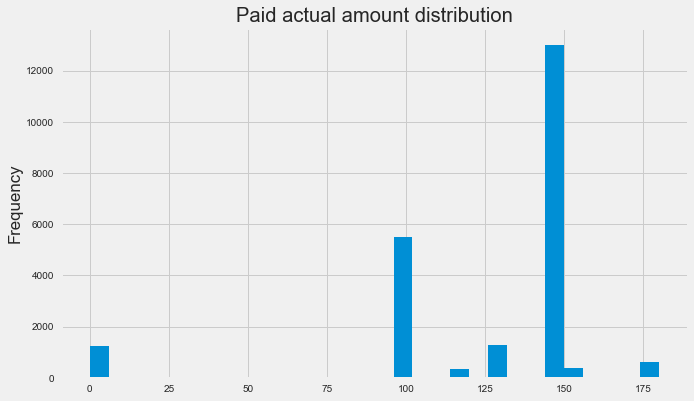

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.rcParams['figure.figsize'] = (10, 6)
params= plt.rcParams

params['figure.figsize'] = (10, 6)
params['font.family'] = 'arial'


trans.loc[trans['actual_amount_paid'] < 250, 'actual_amount_paid'].dropna().plot.hist(bins = 30);
plt.title('Paid actual amount distribution');

#### Domain Knowledge Features

Before creating the entity from this dataframe, we can create a few new variables based on domain knowledge. Just because we are automatically going to make hundreds of features doesn't mean we can't use our own expertise. Featuretools will build on top of our knowledge by stacking more primitives on top of any variables that we define.

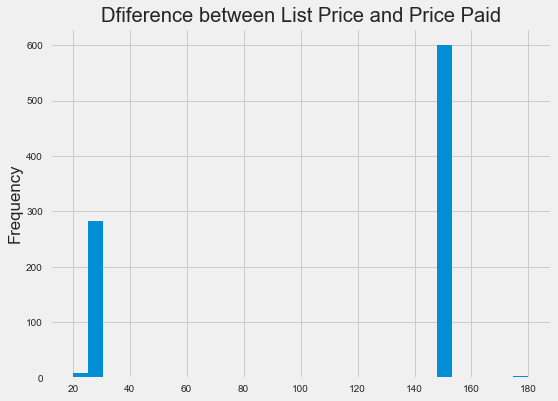

In [139]:
# Difference between listing price and price paid
trans['price_difference'] = trans['plan_list_price'] - trans['actual_amount_paid']

# Planned price per day
trans['planned_daily_price'] = trans['plan_list_price'] / trans['payment_plan_days']

# Actual price per day
trans['daily_price'] = trans['actual_amount_paid'] / trans['payment_plan_days']

trans.loc[trans['price_difference'] > 0, 'price_difference'].plot.hist(bins = 30, 
                                                                       figsize = (8, 6));
plt.title('Dfiference between List Price and Price Paid');

There is no `index` in this dataframe so we have to specify to make an index and pass in a name. There is a `time_index`, the time of the transaction, which will be critical when filtering data based on cutoff times to make features. Again, we also need to specify several variable types.

There is one slight anomaly with the transactions where some membership expire dates are after the transactions date, so we will filter those out.

In [140]:
# Filter anomalies
trans = trans[trans['membership_expire_date'] > trans['transaction_date']]

In [141]:
# Create entity from transactions
es.entity_from_dataframe(entity_id='transactions', dataframe=trans,
                         index = 'transactions_index', make_index = True,
                         time_index = 'transaction_date', 
                         variable_types = {'payment_method_id': vtypes.Categorical, 
                                           'is_auto_renew': vtypes.Boolean, 'is_cancel': vtypes.Boolean})

Entityset: customers
  Entities:
    members [Rows: 6658, Columns: 6]
    transactions [Rows: 22329, Columns: 13]
  Relationships:
    No relationships

### Logs

The `logs` contain user listening behavior. As before we'll make a few domain knowledge columns before adding to the `EntitySet`. 

In [ ]:
logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,6+/V1NwBbqjBOCvRSDueeJZ58F4DY7h7fG6fSZtHaAE=,2017-03-04,29,28,18,11,111,79,34727.142
1,E2aBGFTKR6jzp+1knh7JOOF39gLuu+CoZMWaAL/DA0M=,2017-03-27,1,0,2,0,184,173,33408.719
2,g7exJzakJlHXwzUydnShY5w24WXSwJyS6QqgoFeyr7g=,2017-03-15,0,0,0,0,21,21,4951.000
3,X+i9OmM3P42cETt5gPkOnz8vXGViQL5/M/NMiMQ+Olc=,2017-03-13,3,1,0,0,33,27,8755.599
4,tbl8blAVl6j4A8zW1Gnyg78Hc0LAQzzcYesmzgJ7ofs=,2017-03-27,6,5,0,0,2,6,1035.853


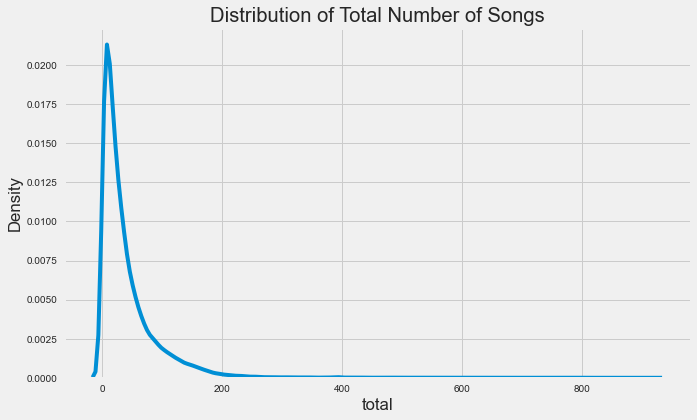

In [52]:
# Make a few features by hand
logs['total'] = logs[['num_25', 'num_50', 'num_75', 'num_985', 'num_100']].sum(axis = 1)
logs['percent_100'] = logs['num_100'] / logs['total']
logs['percent_unique'] = logs['num_unq'] / logs['total']
logs['seconds_per_song'] = logs['total_secs'] / logs['total'] 

import seaborn as sns

sns.kdeplot(logs['total']);
plt.title('Distribution of Total Number of Songs');

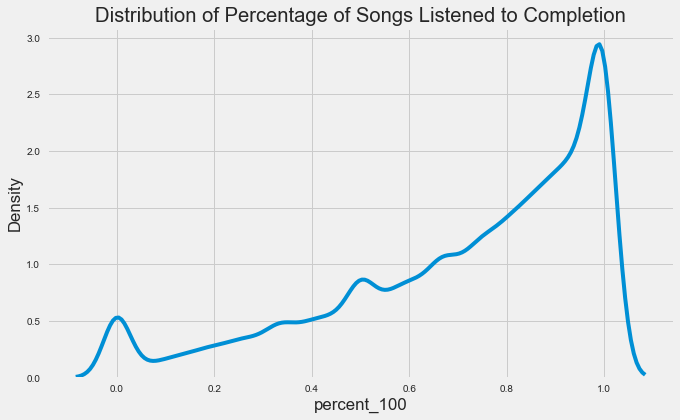

In [110]:
sns.kdeplot(logs['percent_100']);
plt.title('Distribution of Percentage of Songs Listened to Completion');

There is `time_index` in the logs although no `index` present.

In [142]:
es.entity_from_dataframe(entity_id='logs', dataframe=logs,
                         index = 'logs_index', make_index = True,
                         time_index = 'date')

Entityset: customers
  Entities:
    members [Rows: 6658, Columns: 6]
    transactions [Rows: 22329, Columns: 13]
    logs [Rows: 87658, Columns: 10]
  Relationships:
    No relationships

In [157]:
#Slicing into an entity as an example
es['members'].df

,msno,bd,gender,registration_init_time,city,registered_via
0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,28,female,2004-03-27,13,9
9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,0,female,2004-03-27,15,9
9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=,9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=,34,male,2004-03-27,22,9
HGB6FSywR6chH7I0wfBTORrxsNnWzC1jld6z0irUd+8=,HGB6FSywR6chH7I0wfBTORrxsNnWzC1jld6z0irUd+8=,32,female,2004-03-27,5,9
EaWla77Wke5BymN0uy12PqXl//nysa4iU4m8Ac7WxqE=,EaWla77Wke5BymN0uy12PqXl//nysa4iU4m8Ac7WxqE=,25,male,2004-03-29,21,9
...,...,...,...,...,...,...
C018u6Z3bKhdLevKHfd4qTpjH1ErbpOfQEXE54McQ8Q=,C018u6Z3bKhdLevKHfd4qTpjH1ErbpOfQEXE54McQ8Q=,53,female,2017-04-28,5,3
ieEL4ucldp75Ej+cuuLQm0Lybq8eNfvvB2gubl0gX+Y=,ieEL4ucldp75Ej+cuuLQm0Lybq8eNfvvB2gubl0gX+Y=,26,female,2017-04-28,5,3
Emm3bVSldO9dEjGZxZl3s+CxNG97aLc4DlYxXyQxDIo=,Emm3bVSldO9dEjGZxZl3s+CxNG97aLc4DlYxXyQxDIo=,0,NaN,2017-04-29,1,9
WDlhgZYDaWFiJqmSwDc8lYjHqxZMJ9HVZpUAA1B34rU=,WDlhgZYDaWFiJqmSwDc8lYjHqxZMJ9HVZpUAA1B34rU=,44,female,2017-04-29,1,3


Making features by hand may seem counterintuitive if we are using automated feature engineering, but the benefits of doing this before using Featuretools is that these features can be stacked on top of to build deep features. Automated feature engineering will therefore take our existing hand-built features and extract more value from them by combining them with other features.

Another method to improve the power of deep feature synthesis is through interesting values, which specify conditional statements used to build features.

### Interesting Values

In order to create conditional features, we can set interesting values for existing columns in the data. The following code will be used to build features conditional on the value of `is_cancel` and `is_auto_renew` in the transactions data. The primitives used for the conditional features are specified as `where_primitives` in the call to Deep Feature Synthesis. For example, if we used a `mean` primitive along with the following interesting values, we will get a mean of transactions where the transaction was cancelled, as well as the mean of transactions where the transaction was not cancelled. 

In [158]:
es['transactions']['is_cancel'].interesting_values = [0, 1]
es['transactions']['is_auto_renew'].interesting_values = [0, 1]

In [159]:
es

Entityset: customers
  Entities:
    members [Rows: 6658, Columns: 6]
    transactions [Rows: 22329, Columns: 13]
    logs [Rows: 87658, Columns: 10]
  Relationships:
    No relationships

# Relationships

Table relationships should be familiar to anyone who has worked with relational databases and the idea is the same in Featuretools. We use relationships to specify how examples in one table relate to examples in other tables. The entityset structure for this problem is fairly simple as there are only three entities with two relationships.  `members` is the parent of `logs` and `transactions`. In both relationships, the parent and child variable is `msno`, the customer id.

The two relationships are: one linking `members` to `transactions` and one linking `members` to `logs`. The order for relationships in featuretools is parent variable, child variable.

In [160]:
# Relationships (parent, child)
r_member_transactions = ft.Relationship(es['members']['msno'], es['transactions']['msno'])
r_member_logs = ft.Relationship(es['members']['msno'], es['logs']['msno'])

es.add_relationships([r_member_transactions, r_member_logs])

Entityset: customers
  Entities:
    members [Rows: 6658, Columns: 6]
    transactions [Rows: 22329, Columns: 13]
    logs [Rows: 87658, Columns: 10]
  Relationships:
    transactions.msno -> members.msno
    logs.msno -> members.msno

### Cutoff Times

`cutoff_times` are a critical piece of any time based machine learning problem. The label times dataframe has columns of member id, cutoff time, and label. __For each cutoff time, only data from before the cutoff time can be used to build features for that label.__ This is one of the greatest advantages of Featuretools compared to manual feature engineering: __Featuretools automatically filters our data based on the cutoff times to ensure that all the features are valid for machine learning.__ Normally, we would have to take extreme care to make sure all of our features are valid, but Featreutools is able to implement the filtering logic behind the scenes for us.

All we have to do is make sure to pass in the correct label times for the prediction problem we want to solve.

In [165]:
cutoff_times.rename(columns = {'cutoff_time' : 'time'}, inplace= True)
cutoff_times.head()

,msno,time,label,days_to_churn,churn_date
0,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-08-01,0.0,NaN,NaN
1,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-09-01,0.0,NaN,NaN
2,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-10-01,0.0,NaN,NaN
3,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-11-01,0.0,NaN,NaN
4,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-12-01,0.0,NaN,NaN


In [167]:
cutoff_times = cutoff_times.drop_duplicates(subset = ['msno', 'time'])
cutoff_times.head()

,msno,time,label,days_to_churn,churn_date
0,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-08-01,0.0,NaN,NaN
1,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-09-01,0.0,NaN,NaN
2,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-10-01,0.0,NaN,NaN
3,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-11-01,0.0,NaN,NaN
4,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-12-01,0.0,NaN,NaN


# Deep Feature Synthesis

With the entities and relationships fully defined, we are ready to run [Deep Feature Synthesis (DFS)](https://www.featurelabs.com/blog/deep-feature-synthesis/). This process applies feature engineering building blocks called [feature primitives](https://docs.featuretools.com/automated_feature_engineering/primitives.html) to a dataset to build hundreds of features. Feature primitives are basic operations of two types - transforms and aggregations - that stack to build deep features (for more information see the previous linked resources). These includes many operations that we would traditionally carry out by hand, but automated feature engineering saves us from having to implement these features one at a time. 

The call to `ft.dfs` needs the entityset which holds all the tables and relationships between them, the `target_entity` to make features for, the specific primitives, the maximum stacking of primitives (`max_depth`), the `cutoff_times`, and a number of optional parameters.

To start, we'll use the default aggregation and transformation primitives as well as two `where_primitives` and see how many features this generates. To only generate the definitions of the features, we pass in `features_only = True`.

For full details on Deep Feature Synthesis, take a look at [the documentation](https://docs.featuretools.com/api_reference.html#deep-feature-synthesis). 

In [168]:
feature_defs = ft.dfs(entityset=es, target_entity='members', 
                      cutoff_time = cutoff_times,
                      where_primitives = ['sum', 'mean'],
                      max_depth=2, features_only=True)

In [169]:
print(f'This will generate {len(feature_defs)} features.')

This will generate 164 features.


In [170]:
feature_defs_2 = ft.dfs(entityset=es, target_entity='members', 
                      cutoff_time = cutoff_times,
                      where_primitives = ['sum', 'mean', 'max', 'min'],
                      max_depth=4, features_only=True)
print(f'This will generate {len(feature_defs_2)} features.')

This will generate 212 features.


In [171]:
import random; random.seed(42)
random.sample(feature_defs, 10)

[<Feature: NUM_UNIQUE(logs.YEAR(date))>,
 <Feature: SKEW(transactions.daily_price)>,
 <Feature: MAX(transactions.daily_price)>,
 <Feature: SKEW(logs.num_75)>,
 <Feature: MIN(logs.num_50)>,
 <Feature: MEAN(logs.num_985)>,
 <Feature: STD(transactions.payment_plan_days)>,
 <Feature: PERCENT_TRUE(transactions.is_cancel)>,
 <Feature: SUM(transactions.daily_price WHERE is_auto_renew = 1)>,
 <Feature: MIN(transactions.price_difference)>]

We can see that Featuretools has built almost 200 features automatically for us using the table relationships and feature primitives. If built by hand, each of these features would require minutes of work, totaling many hours to build 188 features. Moreover, although the features are not necessarily intuitive, they are easy to explain in natural language because they are simple operations stacked on top of each other.

## Specify Primitives 

Now we'll do a call to `ft.dfs` specifying the primitives to use. Often, these will depend on the problem and can involve domain knowledge. The best way to choose primitives is by trying out a variety and seeing which perform the best. Like many operations in machine learning, choosing primitives is still largely an empirical, rather than theoretical, practice.

### Aggregation Primitives

In [66]:
all_p = ft.list_primitives()
trans_p = all_p.loc[all_p['type'] == 'transform'].copy()
agg_p = all_p.loc[all_p['type'] == 'aggregation'].copy()

pd.options.display.max_colwidth = 100
agg_p.head()

,name,type,dask_compatible,koalas_compatible,description,valid_inputs,return_type
0,first,aggregation,False,False,Determines the first value in a list.,Variable,None
1,avg_time_between,aggregation,False,False,Computes the average number of seconds between consecutive events.,DatetimeTimeIndex,Numeric
2,skew,aggregation,False,False,Computes the extent to which a distribution differs from a normal distribution.,Numeric,Numeric
3,any,aggregation,True,False,Determines if any value is 'True' in a list.,Boolean,Boolean
4,last,aggregation,False,False,Determines the last value in a list.,Variable,None


## Transform Primitives

In [67]:
trans_p.tail()

,name,type,dask_compatible,koalas_compatible,description,valid_inputs,return_type
79,url_to_domain,transform,False,False,Determines the domain of a url.,URL,Categorical
80,time_since,transform,True,False,Calculates time from a value to a specified cutoff datetime.,Datetime,Numeric
81,or,transform,True,True,Element-wise logical OR of two lists.,Boolean,Boolean
82,not_equal_scalar,transform,True,True,Determines if values in a list are not equal to a given scalar.,Variable,Boolean
83,scalar_subtract_numeric_feature,transform,True,True,Subtract each value in the list from a given scalar.,Numeric,Numeric


In [172]:
# Specify aggregation primitives
#agg_primitives = ['sum', 'time_since_last', 'avg_time_between', 'all', 'mode', 'num_unique', 'min', 'last', 'mean', 'percent_true', 'max', 'std', 'count']
agg_primitives = ['sum', 'time_since_last', 'avg_time_between', 'all', 'mode', 'num_unique', 'min', 'last', 
                  'mean', 'percent_true', 'max', 'std', 'count']

In [173]:
# Specify transformation primitives
trans_primitives = ['cum_sum', 'day', 'month', 'diff', 'time_since_previous']
#trans_primitives = ['weekend', 'cum_sum', 'day', 'month', 'diff', 'percentile','IsWeekend', 'time_since_previous']

### Where Primitives

These primitives are applied to the `interesting_values` to build conditional features. 

In [174]:
# Specify where primitives
where_primitives = ['sum', 'mean', 'percent_true', 'all', 'any']
#where_primitives = ['sum', 'mean', 'percent_true', 'all', 'any', 'where_not_equal', 'where_equal', 
                    #'where_greater_than', 'where_greater_than_equal', 'where_less_than', 'where_less_than_equal']

## Custom Primitives

[Custom primitives](https://docs.featuretools.com/automated_feature_engineering/primitives.html#defining-custom-primitives) are one of the most powerful options in Featuretools. We use custom primitives to write our own functions based on domain knowledge and then pass them to `dfs` like any other primitives. Featuretools will then stack our custom primitives with the other primitives, again, in effect, amplifying our domain knowledge.

For this problem, I wrote a custom primitive that calculates the sum of a value in the month prior to the cutoff time. This is actually a primitive I [wrote for another problem](https://github.com/Featuretools/Automated-Manual-Comparison/tree/master/Retail%20Spending) but I can apply it to this problem because primitives are data agnostic. That's one of the benefits of feature primitives: they can work for any problem and writing a custom primitive will pay off many times over.

In [72]:
from featuretools.primitives import make_agg_primitive

def total_previous_month(numeric, datetime, time):
    """Return total of `numeric` column in the month prior to `time`."""
    df = pd.DataFrame({'value': numeric, 'date': datetime})
    previous_month = time.month - 1
    year = time.year
   
    # Handle January
    if previous_month == 0:
        previous_month = 12
        year = time.year - 1
        
    # Filter data and sum up total
    df = df[(df['date'].dt.month == previous_month) & (df['date'].dt.year == year)]
    total = df['value'].sum()
    
    return total

In [78]:
# testing the defined function
numeric_1 = [10, 12, 14, 15, 19, 22, 9, 8, 8, 11]
numeric_2 = [10, 12, 14, 5, 7, 8]
dates_1 = pd.date_range('2018-01-01', '2018-03-01', periods = len(numeric_1))
dates_2 = pd.date_range('2018-01-01', '2018-03-01', periods = len(numeric_2))
print (pd.DataFrame({'value': numeric_1, 'date': dates_1}).head(6))
print (pd.DataFrame({'value': numeric_2, 'date': dates_2}).head(6))
print (total_previous_month(numeric_1, dates_1, pd.datetime(2018, 2, 1)))
print (total_previous_month(numeric_2, dates_2, pd.datetime(2018, 3, 1)))

   value                date
0     10 2018-01-01 00:00:00
1     12 2018-01-07 13:20:00
2     14 2018-01-14 02:40:00
3     15 2018-01-20 16:00:00
4     19 2018-01-27 05:20:00
5     22 2018-02-02 18:40:00
   value                date
0     10 2018-01-01 00:00:00
1     12 2018-01-12 19:12:00
2     14 2018-01-24 14:24:00
3      5 2018-02-05 09:36:00
4      7 2018-02-17 04:48:00
5      8 2018-03-01 00:00:00
70
12


### Custom Primitive Implementation

Making a custom primitive is simple: first we define a function (`total_previous_month`) and then we `make_agg_primitive` with `input_type[s]`, a `return_type`, and whether or not the primitive requires the `cutoff_time` through `uses_calc_time`. 

This primitive is an aggregation primitive because it takes in multiple numbers - transactions for the previous month - and returns a single number - the total of the transactions. 

In [79]:
# Takes in a number and outputs a number
total_previous = make_agg_primitive(total_previous_month, input_types = [ft.variable_types.Numeric,
                                                                         ft.variable_types.Datetime],
                                    return_type = ft.variable_types.Numeric, 
                                    uses_calc_time = True)

Now just have to pass this in as another aggregation primitive for Featuretools to use it in calculations.


The second custom primitive finds the time since a previous true value. This is originally intended for the `is_cancel` variable in the `transactions` dataframe, but it can work for any Boolean variable. It simply finds the time between True examples.

In [80]:
def time_since_true(boolean, datetime):
    """Calculate time since previous true value"""
    
    if np.any(np.array(list(boolean)) == 1):
        # Create dataframe sorted from oldest to newest 
        df = pd.DataFrame({'value': boolean, 'date': datetime}).\
                sort_values('date', ascending = False).reset_index()

        older_date = None

        # Iterate through each date in reverse order
        for date in df.loc[df['value'] == 1, 'date']:

            # If there was no older true value
            if older_date == None:
                # Subset to times on or after true
                times_after_idx = df.loc[df['date'] >= date].index

            else:
                # Subset to times on or after true but before previous true
                times_after_idx = df.loc[(df['date'] >= date) & (df['date'] < older_date)].index
            older_date = date
            # Calculate time since previous true
            df.loc[times_after_idx, 'time_since_previous'] = (df.loc[times_after_idx, 'date'] - date).dt.total_seconds()

        return list(df['time_since_previous'])[::-1]
    
    # Handle case with no true values
    else:
        return [np.nan for _ in range(len(boolean))]

In [ ]:
booleans = []
dates = []
df = pd.DataFrame({'value': booleans, 'date': dates})
time_since_true(df['value'], df['date'])

[]

In [82]:
#testing the function
booleans = [1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
dates = pd.date_range('2018-01-01', '2018-03-01', periods = len(booleans))
df = pd.DataFrame({'value': booleans, 'date': dates})
time_since_true(df['value'], df['date'])

[0.0,
 509760.00000000006,
 1019520.0000000001,
 1529280.0,
 2039040.0000000002,
 0.0,
 0.0,
 0.0,
 509760.00000000006,
 1019520.0000000001,
 1529280.0]

In [83]:
booleans = [1, 0, 0]
dates = pd.date_range('2018-01-01', '2018-03-01', periods = len(booleans))
time_since_true(booleans, dates)

[0.0, 2548800.0, 5097600.0]

In [84]:
booleans = [0, 0]
dates = pd.date_range('2018-01-01', '2018-03-01', periods = len(booleans))
time_since_true(booleans, dates)

[nan, nan]

This is a transformation primitive since it acts on multiple columns in the same table. The returned list is the same length as the original column.

In [85]:
from featuretools.primitives import make_trans_primitive

# Specify the inputs and return
time_since = make_trans_primitive(time_since_true, 
                                  input_types = [vtypes.Boolean, vtypes.Datetime],
                                  return_type = vtypes.Numeric)

Let's add the two custom primitives to the respective lists. In the final version of feature engineering, I did not use the `time_since` primitive. I ran into problems with the implementation but would encourage anyone to try and fix it or build their own custom primitive[s].

In [175]:
agg_primitives.append(total_previous)
#trans_primitives.append(time_since)

## Deep Feature Synthesis with Specified Primitives

We'll again run Deep Feature Synthesis to make the feature definitions this time using the selected primitives and the custom primitives. 

In [176]:
feature_defs = ft.dfs(entityset=es, target_entity='members', 
                      cutoff_time = cutoff_times, 
                      agg_primitives = agg_primitives,
                      trans_primitives = trans_primitives,
                      where_primitives = where_primitives,
                      chunk_size = len(cutoff_times), 
                      cutoff_time_in_index = True,
                      max_depth = 2, features_only = True)

In [177]:
print(f'This will generate {len(feature_defs)} features.')

This will generate 728 features.


In [178]:
random.sample(feature_defs, 15)

[<Feature: CUM_SUM(TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, membership_expire_date))>,
 <Feature: MEAN(logs.CUM_SUM(num_25))>,
 <Feature: MIN(transactions.payment_plan_days)>,
 <Feature: MIN(transactions.actual_amount_paid)>,
 <Feature: MIN(logs.total_secs)>,
 <Feature: MEAN(transactions.actual_amount_paid WHERE is_auto_renew = 0)>,
 <Feature: MEAN(transactions.planned_daily_price WHERE is_cancel = 1)>,
 <Feature: CUM_SUM(LAST(logs.num_75))>,
 <Feature: DAY(LAST(logs.date))>,
 <Feature: MEAN(transactions.plan_list_price)>,
 <Feature: CUM_SUM(STD(logs.num_unq))>,
 <Feature: MEAN(transactions.DIFF(plan_list_price) WHERE is_cancel = 1)>,
 <Feature: DIFF(MIN(logs.num_75))>,
 <Feature: DIFF(TOTAL_PREVIOUS_MONTH(transactions.payment_plan_days, transaction_date))>,
 <Feature: CUM_SUM(MIN(logs.num_unq))>]

We can see that our custom primitive `TOTAL_PREVIOUS_MONTH` has been applied to create more features. The benefit of custom primitives are that they can be used to encode specific domain knowledge into the feature engineering process. Moreover, we don't get just the custom primitive itself, we also get features that are stacked on top of the primitive.

# Run Deep Feature Synthesis

Once we're happy with the features that will be generated, we can run deep feature synthesis to make the actual features. We need to change `feature_only` to `False` and then we're good to go.

In [179]:
from timeit import default_timer as timer

start = timer()
feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity='members', 
                                      cutoff_time = cutoff_times, 
                                      agg_primitives = agg_primitives,
                                      trans_primitives = trans_primitives,
                                      where_primitives = where_primitives,
                                      max_depth = 1, features_only = False,
                                      verbose = 1, chunk_size = 100,  
                                      n_jobs = 1,
                                      cutoff_time_in_index = True)
end = timer()
print(f'{round(end - start)} seconds elapsed.')

Built 179 features
Elapsed: 13:20 | Progress: 100%|██████████
800 seconds elapsed.


The `chunk_size` is a parameter that may need to be adjusted to optimize the calculation. I suggest playing around with this parameter to find the optimal value. Generally I've found that a large value makes the calculation proceed quicker although it depends on the machine in use and the number of unique cutoff times. 

In [180]:
feature_matrix.head()

bd gender  city  \
msno                                         time                          
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE= 2015-08-01 NaN    NaN   NaN   
                                             2015-09-01 NaN    NaN   NaN   
                                             2015-10-01 NaN    NaN   NaN   
                                             2015-11-01 NaN    NaN   NaN   
                                             2015-12-01 NaN    NaN   NaN   

                                                         registered_via  \
msno                                         time                         
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE= 2015-08-01             NaN   
                                             2015-09-01             NaN   
                                             2015-10-01             NaN   
                                             2015-11-01             NaN   
                                             2015-12-01             NaN   

                                                        ALL(transactions.is_auto_renew)  \
msno                                         time                                         
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE= 2015-08-01                             NaN   
                                             2015-09-01                             NaN   
                                             2015-10-01                             NaN   
                                             2015-11-01                             NaN   
                                             2015-12-01                             NaN   

                                                        ALL(transactions.is_cancel)  \
msno                                         time                                     
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE= 2015-08-01                         NaN   
                                             2015-09-01                         NaN   
                                             2015-10-01                         NaN   
                                             2015-11-01                         NaN   
                                             2015-12-01                         NaN   

                                                         AVG_TIME_BETWEEN(transactions.transaction_date)  \
msno                                         time                                                          
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE= 2015-08-01                                              NaN   
                                             2015-09-01                                              NaN   
                                             2015-10-01                                              NaN   
                                             2015-11-01                                              NaN   
                                             2015-12-01                                              NaN   

                                                         COUNT(transactions)  \
msno                                         time                              
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE= 2015-08-01                  0.0   
                                             2015-09-01                  0.0   
                                             2015-10-01                  0.0   
                                             2015-11-01                  0.0   
                                             2015-12-01                  0.0   

                                                         LAST(transactions.actual_amount_paid)  \
msno                                         time                                                
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE= 2015-08-01                                    NaN   
                                             2015-09-01                                    NaN   
                                        

In [183]:
feature_matrix.columns

Index(['bd', 'gender', 'city', 'registered_via',
       'ALL(transactions.is_auto_renew)', 'ALL(transactions.is_cancel)',
       'AVG_TIME_BETWEEN(transactions.transaction_date)',
       'COUNT(transactions)', 'LAST(transactions.actual_amount_paid)',
       'LAST(transactions.daily_price)',
       ...
       'SUM(transactions.planned_daily_price WHERE is_auto_renew = 0)',
       'SUM(transactions.planned_daily_price WHERE is_cancel = 0)',
       'SUM(transactions.planned_daily_price WHERE is_auto_renew = 1)',
       'SUM(transactions.price_difference WHERE is_cancel = 1)',
       'SUM(transactions.price_difference WHERE is_auto_renew = 0)',
       'SUM(transactions.price_difference WHERE is_cancel = 0)',
       'SUM(transactions.price_difference WHERE is_auto_renew = 1)', 'label',
       'days_to_churn', 'churn_date'],
      dtype='object', length=182)

In [ ]:
feature

We can save these feature definitions as a binary file which will allow us to make the same exact features for another entityset of the same format. This is useful when we have multiple partitions and we want to make the same features for each. Instead of remaking the feature definitions, we pass in the same feature definitions to a call to `calculate_feature_matrix`.

In [181]:
ft.save_features(feature_defs, './data/churn/features.txt')

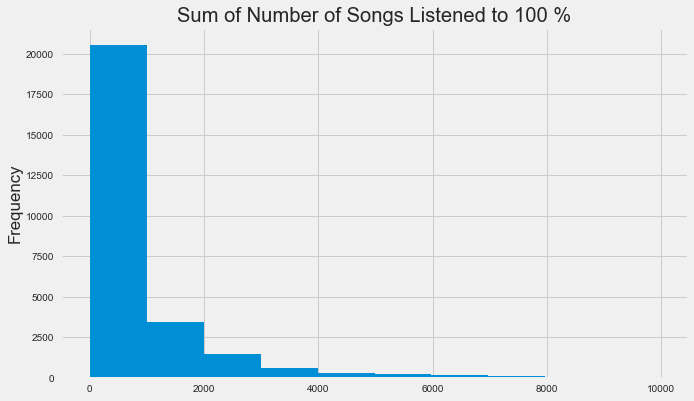

In [182]:
feature_matrix.loc[feature_matrix['SUM(logs.num_100)'] < 10000, 'SUM(logs.num_100)'].plot.hist();
plt.title('% of Sum of Number of Songs Listened to 100 %');

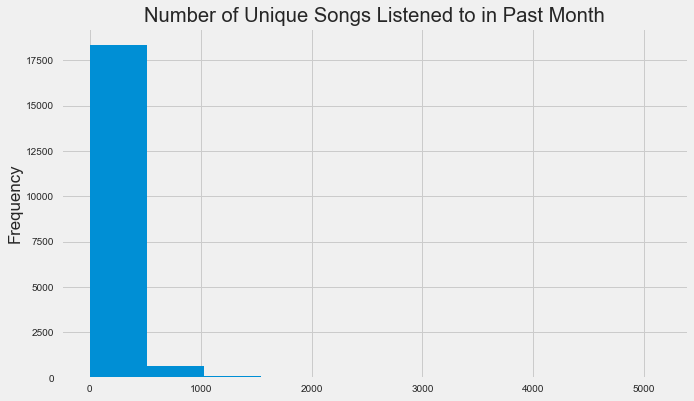

In [184]:
feature_matrix['TOTAL_PREVIOUS_MONTH(logs.num_unq, date)'].plot.hist()
plt.title('Number of Unique Songs Listened to in Past Month');

In [190]:
feature_matrix['TOTAL_PREVIOUS_MONTH(logs.num_unq, date)'].describe()

count    19149.000000
mean       105.669121
std        207.530922
min          0.000000
25%          0.000000
50%          9.000000
75%        140.000000
max       5137.000000
Name: TOTAL_PREVIOUS_MONTH(logs.num_unq, date), dtype: float64

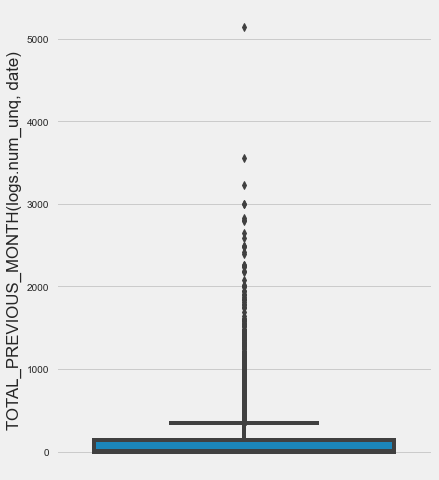

In [186]:
plt.figure(figsize = (6, 8))
sns.boxplot(y = feature_matrix['TOTAL_PREVIOUS_MONTH(logs.num_unq, date)']);

In [ ]:
pairplot_head = feature_matrix.head(3)
sns.pairplot(pairplot_head)

In [ ]:
pairplot_tail = feature_matrix.tail(5)
sns.pairplot(pairplot_tail)

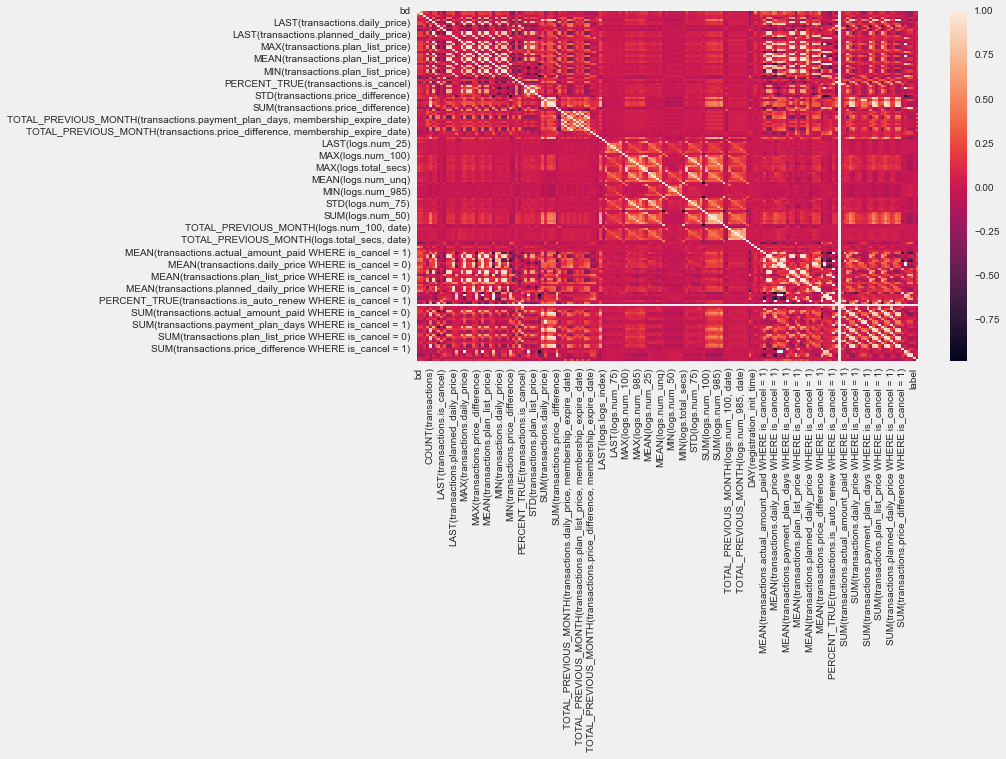

In [194]:
#plt.rcParams['figure.figsize'] = (10, 6)
params= plt.rcParams

params['figure.figsize'] = (10, 6)
params['font.family'] = 'arial'

sns.heatmap(feature_matrix.corr());

In [199]:
data= feature_matrix.corr().abs()

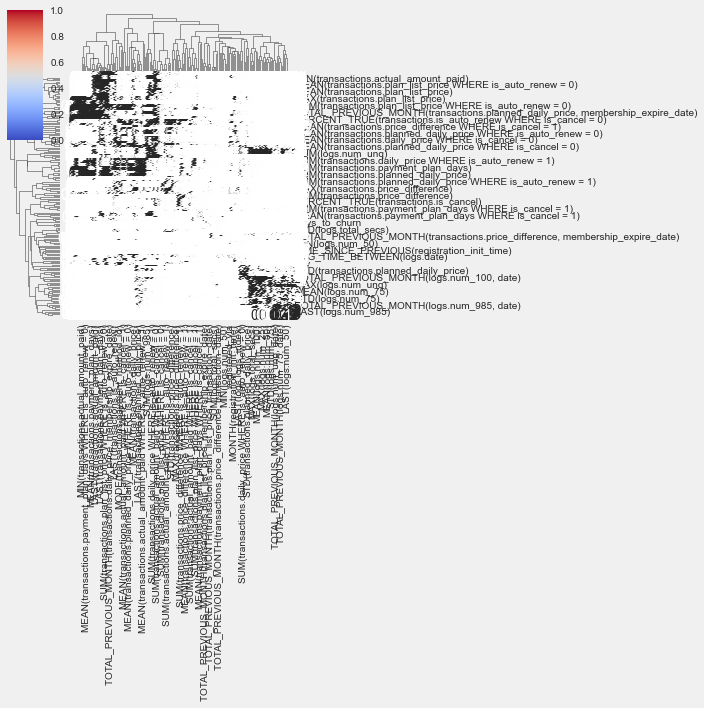

In [200]:
data = data.fillna(0)
sns.clustermap(data, annot=True, cmap='coolwarm');
plt.show();

In [187]:
feature_defs = ft.load_features('./data/churn/features.txt')
print(f'There are {len(feature_defs)} features.')

There are 179 features.


# Feature engineering highlights

Automated feature engineering is a significant improvement over manual feature engineering in terms of both time and modeling performance. In this notebook, we implemented an automated feature engineering workflow with Featuretools for the customer churn problem. Given customer data and label times, we can now calculate a feature matrix with several hundred relevant features for predicting customer churn while ensuring that our features are made with valid data for each cutoff time. 

Along the way, we implemented a number of Featuretools concepts:

1. An entityset and entities
2. Relationships between entities
3. Cutoff times
4. Feature primitives
5. Custom primitives
6. Deep feature synthesis

These concepts will serve us well in future machine learning projects that we can tackle with automated feature engineering.

## Next Steps

Although we often hear that "data is the fuel of machine learning", data is not exactly a fuel but more like crude oil. _Features_ are the refined product that we feed into a machine learning model to make accurate predictions. After performing prediction engineering and automated feature engineering, the next step is to use these features in a predictive model to estimate the _label_ using the _features_. 

Generating hundreds of features automatically is impressive, but if those features cannot allow a model to learn our prediction problem then they are not mcuch help! The next step is to use our features and labeled historical examples to train a machine learning model to make predictions of customer churn. We'll make sure to test our model using a hold-out testing set to estimate performance on new data. Then, after validating our model, we can use it on new examples by passing the data through the feature engineering process. 

# Modeling

Data cleaning, test-train split (target variable is the time) and use the other variables to predict

### Data cleanup: 
Out data still has null and infinite values that needs to be cleaned first. Also, we need to reset our index so that our multi-index feature matrix becomes operable for train-test split

In [203]:
feature_matrix_original = feature_matrix.copy()

In [204]:
feature_matrix.shape

(27021, 182)

In [205]:
feature_matrix = feature_matrix.replace({'False': 0, 'True': 1})

In [211]:
feature_matrix.iloc[ :, 0]

msno                                          time      
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=  2015-08-01    NaN
                                              2015-09-01    NaN
                                              2015-10-01    NaN
                                              2015-11-01    NaN
                                              2015-12-01    NaN
                                                           ... 
zzoADz+Wl+2t/T3Fv3lTaKUJPIzRGC+Kdxlr6gEeRts=  2016-06-01    0.0
                                              2016-07-01    0.0
                                              2016-08-01    0.0
                                              2016-09-01    0.0
                                              2016-10-01    0.0
Name: bd, Length: 27021, dtype: float64

In [214]:
feature_matrix.loc[:, 'gender']

msno                                          time      
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=  2015-08-01    NaN
                                              2015-09-01    NaN
                                              2015-10-01    NaN
                                              2015-11-01    NaN
                                              2015-12-01    NaN
                                                           ... 
zzoADz+Wl+2t/T3Fv3lTaKUJPIzRGC+Kdxlr6gEeRts=  2016-06-01    NaN
                                              2016-07-01    NaN
                                              2016-08-01    NaN
                                              2016-09-01    NaN
                                              2016-10-01    NaN
Name: gender, Length: 27021, dtype: category
Categories (2, object): ['female', 'male']

In [215]:
feature_matrix.drop(columns=[c for c in ['churn', 'days_to_next_churn',
                                         'churn_date'] if c in feature_matrix], inplace=True)

In [216]:
missing_pct = feature_matrix.isnull().sum() / len(feature_matrix)

In [217]:
to_drop = list((missing_pct[missing_pct > 0.9]).index)
to_drop = [x for x in to_drop if x != 'days_to_churn']
to_drop

['ALL(transactions.is_auto_renew WHERE is_cancel = 1)',
 'MEAN(transactions.actual_amount_paid WHERE is_cancel = 1)',
 'MEAN(transactions.daily_price WHERE is_cancel = 1)',
 'MEAN(transactions.payment_plan_days WHERE is_cancel = 1)',
 'MEAN(transactions.plan_list_price WHERE is_cancel = 1)',
 'MEAN(transactions.planned_daily_price WHERE is_cancel = 1)',
 'MEAN(transactions.price_difference WHERE is_cancel = 1)']

In [218]:
feature_matrix.drop(columns=to_drop, inplace=True)
feature_matrix.shape

(27021, 174)

## Train-test split and mchine learning algorthm

In [222]:
feature_matrix['time'] = pd.to_datetime(feature_matrix['time'])
feature_matrix['time'].describe()

KeyError: 'time'

In [223]:
feature_matrix_reset = feature_matrix.reset_index()
feature_matrix_reset.head()

## Also Reset the index and remove additional index levels if any
#df_reset = df.reset_index().droplevel(level=1)

,msno,time,bd,gender,city,registered_via,ALL(transactions.is_auto_renew),ALL(transactions.is_cancel),AVG_TIME_BETWEEN(transactions.transaction_date),COUNT(transactions),...,SUM(transactions.planned_daily_price WHERE is_cancel = 1),SUM(transactions.planned_daily_price WHERE is_auto_renew = 0),SUM(transactions.planned_daily_price WHERE is_cancel = 0),SUM(transactions.planned_daily_price WHERE is_auto_renew = 1),SUM(transactions.price_difference WHERE is_cancel = 1),SUM(transactions.price_difference WHERE is_auto_renew = 0),SUM(transactions.price_difference WHERE is_cancel = 0),SUM(transactions.price_difference WHERE is_auto_renew = 1),label,days_to_churn
0,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [224]:
feature_matrix_reset.iloc[:, 0]

0        ++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=
1        ++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=
2        ++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=
3        ++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=
4        ++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=
                             ...                     
27016    zzoADz+Wl+2t/T3Fv3lTaKUJPIzRGC+Kdxlr6gEeRts=
27017    zzoADz+Wl+2t/T3Fv3lTaKUJPIzRGC+Kdxlr6gEeRts=
27018    zzoADz+Wl+2t/T3Fv3lTaKUJPIzRGC+Kdxlr6gEeRts=
27019    zzoADz+Wl+2t/T3Fv3lTaKUJPIzRGC+Kdxlr6gEeRts=
27020    zzoADz+Wl+2t/T3Fv3lTaKUJPIzRGC+Kdxlr6gEeRts=
Name: msno, Length: 27021, dtype: object

In [226]:
feature_matrix_reset['time'] = pd.to_datetime(feature_matrix_reset['time'])
feature_matrix_reset['time'].describe()

count                   27021
unique                     28
top       2016-11-01 00:00:00
freq                     1292
first     2015-01-01 00:00:00
last      2017-04-01 00:00:00
Name: time, dtype: object

In [228]:
split_date = pd.datetime(2016, 8, 1)


train = feature_matrix_reset.loc[feature_matrix_reset['time'] < split_date].copy()
test = feature_matrix_reset.loc[feature_matrix_reset['time'] >= split_date].copy()

train.sort_values(['time'], inplace=True)
test.sort_values(['time'], inplace=True)
train.shape, test.shape

((16822, 176), (10199, 176))

In [229]:
len(train) / len(feature_matrix_reset)

0.6225528292809297

In [230]:
train = pd.get_dummies(train.drop(columns=['time', 'msno']))
test = pd.get_dummies(test.drop(columns=['time', 'msno']))

train, test = train.align(test, join='inner', axis=1)
train.shape, test.shape

((16822, 173), (10199, 173))

In [231]:
y, test_y = np.array(train.pop('label')), np.array(test.pop('label'))

y_reg, test_y_reg = np.array(train.pop('days_to_churn')), np.array(
    test.pop('days_to_churn'))

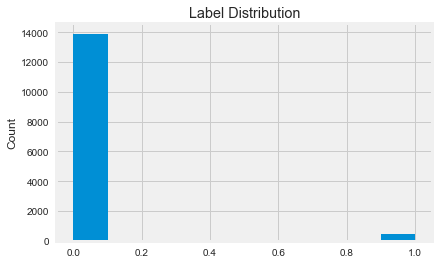

In [233]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(y);
plt.title('Label Distribution');
plt.ylabel('Count');

In [260]:
# infinite and null values are modified
y = np.where(np.isinf(y), np.nan, y)
test_y = np.where(np.isinf(test_y), np.nan, test_y)
y_reg = np.where(np.isinf(y_reg), np.nan, y_reg)
test_y_reg = np.where(np.isinf(test_y_reg), np.nan, test_y_reg)

# Fill NaN values in each array with the median of the non-NaN values
y_median = np.nanmedian(y)
test_y_median = np.nanmedian(test_y)
y_reg_median = np.nanmedian(y_reg)
test_y_reg_median = np.nanmedian(test_y_reg)

y = np.where(np.isnan(y), y_median, y)
test_y = np.where(np.isnan(test_y), test_y_median, test_y)
y_reg = np.where(np.isnan(y_reg), y_reg_median, y_reg)
test_y_reg = np.where(np.isnan(test_y_reg), test_y_reg_median, test_y_reg)

In [234]:
train = train.replace({np.inf: np.nan, -np.inf: np.nan}).fillna(train.median())

In [237]:
test = test.replace({np.inf: np.nan, -np.inf: np.nan}).fillna(train.median())

In [238]:
np.any(train.isnull()), np.any(np.isinf(train))

(False, False)

In [239]:
np.any(test.isnull()), np.any(np.isinf(test))

(False, False)

In [256]:
scaled_train_df = pd.DataFrame(scaled_train)
scaled_test_df = pd.DataFrame(scaled_test)
scaled_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,170
0,0.283019,0.142857,1.000000,0.069565,0.029412,0.083333,0.801075,1.0,0.0,0.965517,...,0.033163,0.5,1.0,0.857143,0.75,0.0,1.0,0.0,1.0,0.0
1,0.000000,0.000000,0.666667,0.069565,0.000000,0.083333,0.827778,1.0,0.0,0.931034,...,0.000000,0.5,1.0,0.857143,0.75,0.0,0.0,0.0,0.0,0.0
2,0.207547,0.190476,0.666667,0.069565,0.000000,0.083333,0.827778,1.0,0.0,0.931034,...,0.000000,0.5,1.0,0.857143,0.75,0.0,0.0,0.0,0.0,0.0
3,0.301887,1.000000,1.000000,0.069565,0.000000,0.083333,0.827778,1.0,0.0,0.931034,...,0.000000,0.5,1.0,0.857143,0.75,0.0,1.0,0.0,0.0,0.0
4,0.264151,0.190476,1.000000,0.069565,0.000000,0.083333,0.827778,1.0,0.0,0.931034,...,0.000000,0.5,1.0,0.857143,0.75,1.0,0.0,0.0,0.0,0.0


In [255]:
scaled_train_df.isna().any().any()

False

In [257]:
scaled_test_df.isna().any().any()

False

In [242]:
from sklearn.preprocessing import MinMaxScaler

# Assuming 'data' is your original dataset with too big values
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.fit_transform(test)

In [263]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

model = LogisticRegression(random_state=50)

def evaluate(model, train, y, test, test_y):
    """Evaluate a machine learning model on four metrics:
       ROC AUC, precision score, recall score, and f1 score.

       Returns the model and the predictions."""

    model.fit(train, y)

    # Predict probabilities and labels
    probs = model.predict_proba(test)[:, 1]
    preds = model.predict(test)

    # Calculate ROC AUC
    roc = roc_auc_score(test_y, probs)
    name = repr(model).split('(')[0]
    print(f"{name}\n")
    print(f'ROC AUC: {round(roc, 4)}')

    # Iterate through metrics
    for metric in [precision_score, recall_score, f1_score]:
        # Use .__name__ attribute to list metric
        print(f'{metric.__name__}: {round(metric(test_y, preds), 4)}')

    return model, preds


model, preds = evaluate(model, scaled_train, y, scaled_test, test_y)

LogisticRegression

ROC AUC: 0.7393
precision_score: 0.0
recall_score: 0.0
f1_score: 0.0


In [264]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=40,
                               min_samples_leaf=50,
                               n_jobs=-1, class_weight='balanced',
                               random_state=50)

model, preds = evaluate(model, train, y, test, test_y)

RandomForestClassifier

ROC AUC: 0.8428
precision_score: 0.0455
recall_score: 0.5079
f1_score: 0.0836


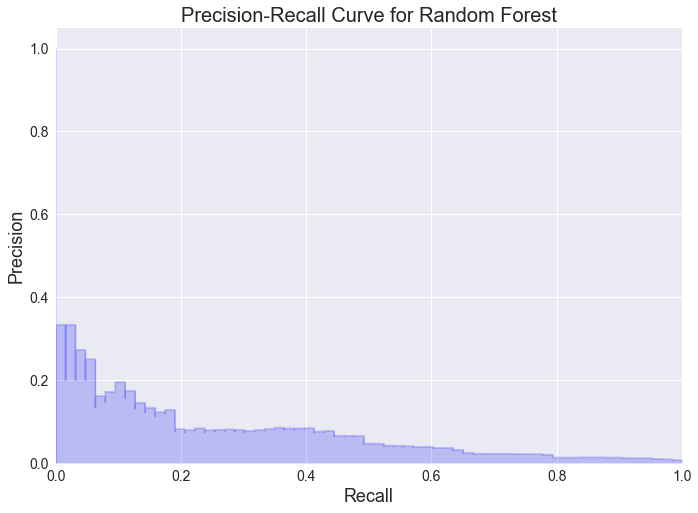

In [302]:
## This is highly inspired by the notebook cited in the beginiing
from sklearn.metrics import precision_recall_curve, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')


def plot_precision_recall(test_y, probs, title='Precision Recall Curve', threshold_selected=None):
    """Plot a precision recall curve for predictions. 
       Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py"""

    precision, recall, threshold = precision_recall_curve(test_y, probs)
    plt.figure(figsize=(10, 8))
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall', size=18)
    plt.ylabel('Precision', size=18)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title, size=20)
    plt.xticks(size=14)
    plt.yticks(size=14)

    if threshold_selected:
        p = precision(np.where(threshold == threshold_selected)[0])
        r = recall(np.where(threshold == threshold_selected)[0])
        plt.scatter(r, p, marker='*', size=200)
        plt.vlines(r, ymin=0, ymax=p, linestyles='--')
        plt.hlines(p, xmin=0, xmax=r, linestyles='--')

    pr = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1],
                       'threshold': threshold})
    return pr


probs = model.predict_proba(test)[:, 1]
pr_data = plot_precision_recall(
    test_y, probs, title='Precision-Recall Curve for Random Forest')

In [266]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.style.use('bmh')
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=22)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=20)
    plt.yticks(tick_marks, classes, size=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 size=20)
    plt.grid(None)
    plt.ylabel('True label', size=22)
    plt.xlabel('Predicted label', size=22)
    plt.tight_layout()

In [269]:
recall_attained = 0.75
recall_above = pr_data.loc[pr_data['recall'] >= recall_attained].copy()
recall_above.sort_values('precision', ascending=False, inplace=True)
recall_above.head()
precision_attained = recall_above.iloc[0, 0]
threshold_required = recall_above.iloc[0, -1]

,precision,recall,threshold
5495,0.020933,0.761905,0.246850
5494,0.020924,0.761905,0.246633
5493,0.020915,0.761905,0.246588
5492,0.020906,0.761905,0.246570
5491,0.020897,0.761905,0.246524


Confusion matrix, without normalization
[[7891 2245]
 [  15   48]]


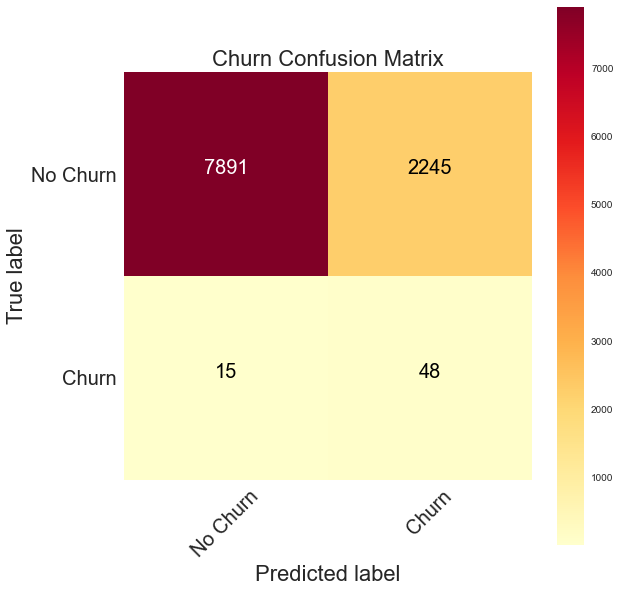

In [270]:
# Make predictions where probability is above threshold
preds = np.zeros(len(test_y))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(test_y, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

In [271]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=train.columns).\
    sort_values('importance', ascending=False)
fi.head(10)

,importance
TIME_SINCE_LAST(transactions.transaction_date),0.084230
AVG_TIME_BETWEEN(transactions.transaction_date),0.037482
"TOTAL_PREVIOUS_MONTH(transactions.payment_plan_days, membership_expire_date)",0.028848
"TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)",0.025338
"TOTAL_PREVIOUS_MONTH(transactions.daily_price, transaction_date)",0.021652
MODE(transactions.payment_method_id),0.019057
"TOTAL_PREVIOUS_MONTH(transactions.planned_daily_price, membership_expire_date)",0.018961
"TOTAL_PREVIOUS_MONTH(transactions.plan_list_price, membership_expire_date)",0.016830
MEAN(transactions.planned_daily_price),0.016089
"TOTAL_PREVIOUS_MONTH(transactions.planned_daily_price, transaction_date)",0.015877


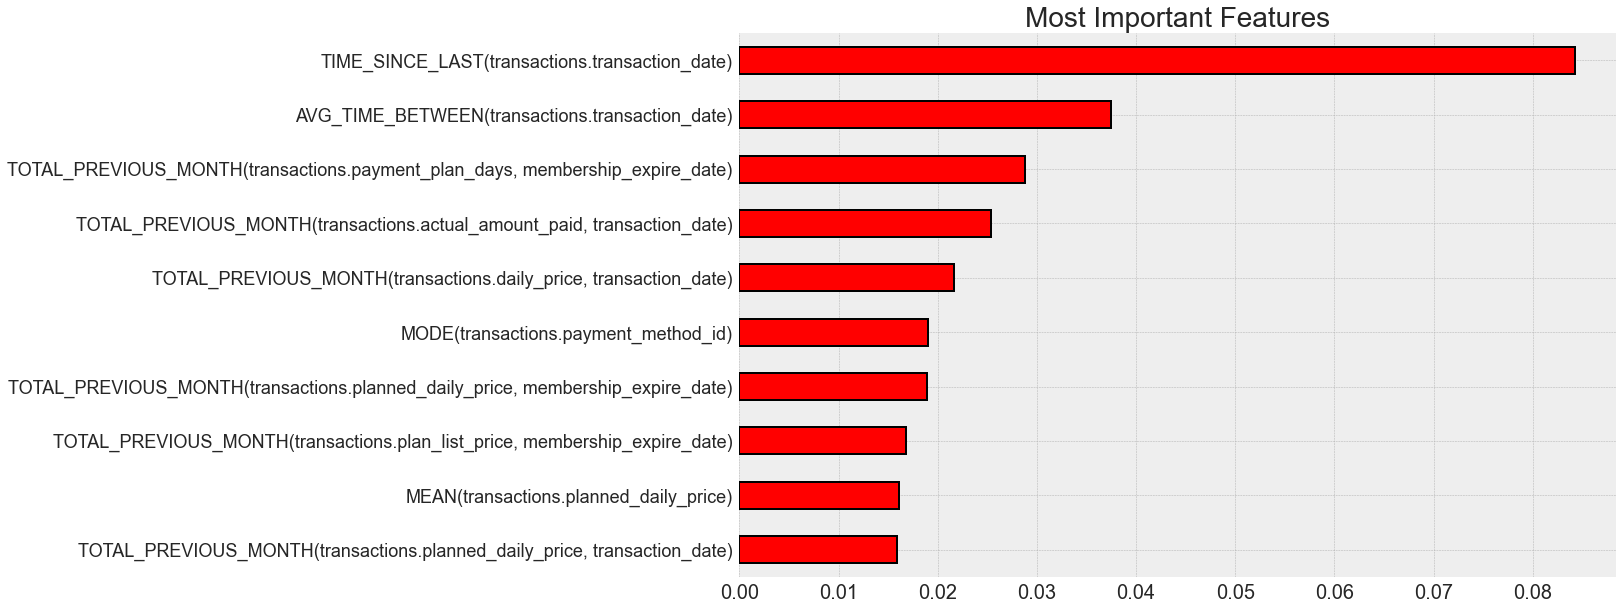

In [272]:
fi.iloc[:10]['importance'].plot.barh(color='r', edgecolor='k',
                                     figsize=(14, 10), linewidth=2)
ax = plt.gca()
ax.invert_yaxis()
plt.xticks(size=20)
plt.yticks(size=18)
plt.title('Most Important Features', size=28);

<Figure size 1440x576 with 0 Axes>

<AxesSubplot:xlabel='TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)', ylabel='Density'>

<AxesSubplot:xlabel='TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)', ylabel='Density'>

Text(0, 0.5, 'Density')

Text(0.5, 0, 'Total_previous_month(transactions.actual_amount_paid, transaction_date)')

Text(0.5, 1.0, 'Distribution of Total_previous_month(transactions.actual_amount_paid, transaction_date)')

<Figure size 1440x576 with 0 Axes>

<AxesSubplot:xlabel='TIME_SINCE_LAST(transactions.transaction_date)', ylabel='Density'>

<AxesSubplot:xlabel='TIME_SINCE_LAST(transactions.transaction_date)', ylabel='Density'>

Text(0, 0.5, 'Density')

Text(0.5, 0, 'Time_since_last(transactions.transaction_date)')

Text(0.5, 1.0, 'Distribution of Time_since_last(transactions.transaction_date)')

<Figure size 1440x576 with 0 Axes>

<AxesSubplot:xlabel='AVG_TIME_BETWEEN(transactions.transaction_date)', ylabel='Density'>

<AxesSubplot:xlabel='AVG_TIME_BETWEEN(transactions.transaction_date)', ylabel='Density'>

Text(0, 0.5, 'Density')

Text(0.5, 0, 'Avg_time_between(transactions.transaction_date)')

Text(0.5, 1.0, 'Distribution of Avg_time_between(transactions.transaction_date)')

<Figure size 1440x576 with 0 Axes>

<AxesSubplot:xlabel='SUM(transactions.payment_plan_days WHERE is_auto_renew = 1)', ylabel='Density'>

<AxesSubplot:xlabel='SUM(transactions.payment_plan_days WHERE is_auto_renew = 1)', ylabel='Density'>

Text(0, 0.5, 'Density')

Text(0.5, 0, 'Sum(transactions.payment_plan_days where is_auto_renew = 1)')

Text(0.5, 1.0, 'Distribution of Sum(transactions.payment_plan_days where is_auto_renew = 1)')

<Figure size 1440x576 with 0 Axes>

<AxesSubplot:xlabel='LAST(transactions.payment_method_id)', ylabel='Density'>

<AxesSubplot:xlabel='LAST(transactions.payment_method_id)', ylabel='Density'>

Text(0, 0.5, 'Density')

Text(0.5, 0, 'Last(transactions.payment_method_id)')

Text(0.5, 1.0, 'Distribution of Last(transactions.payment_method_id)')

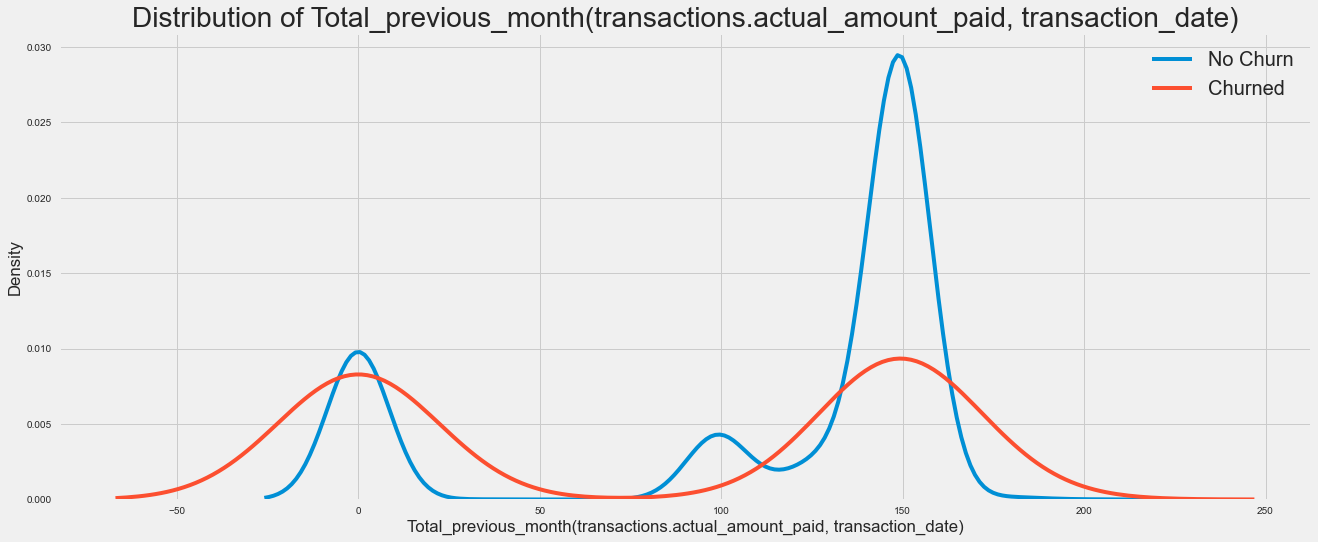

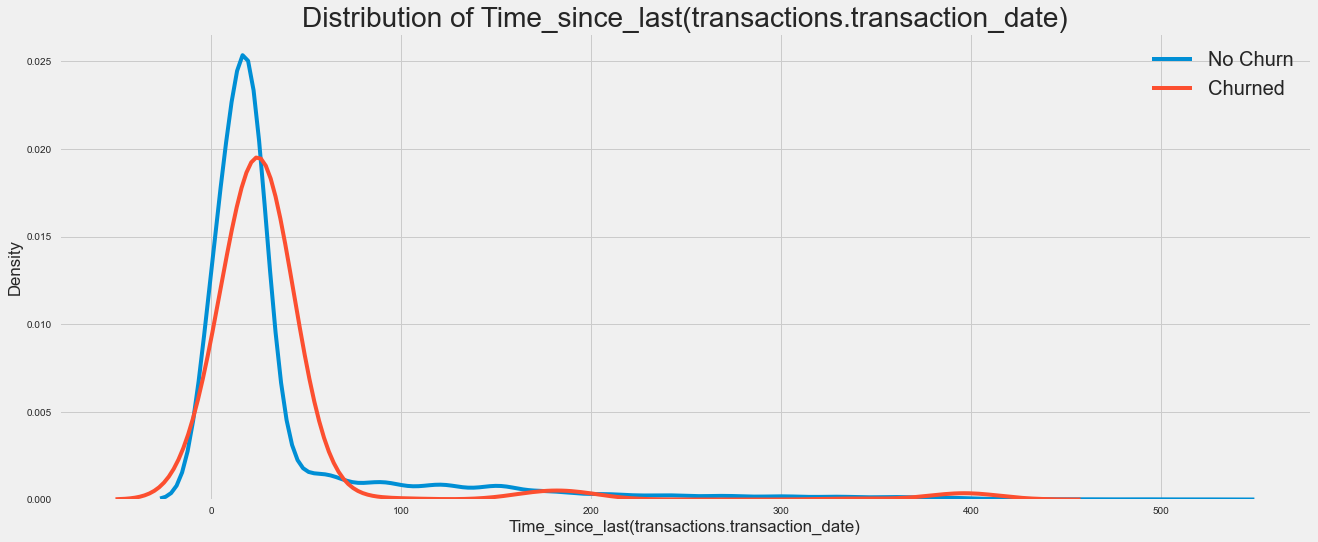

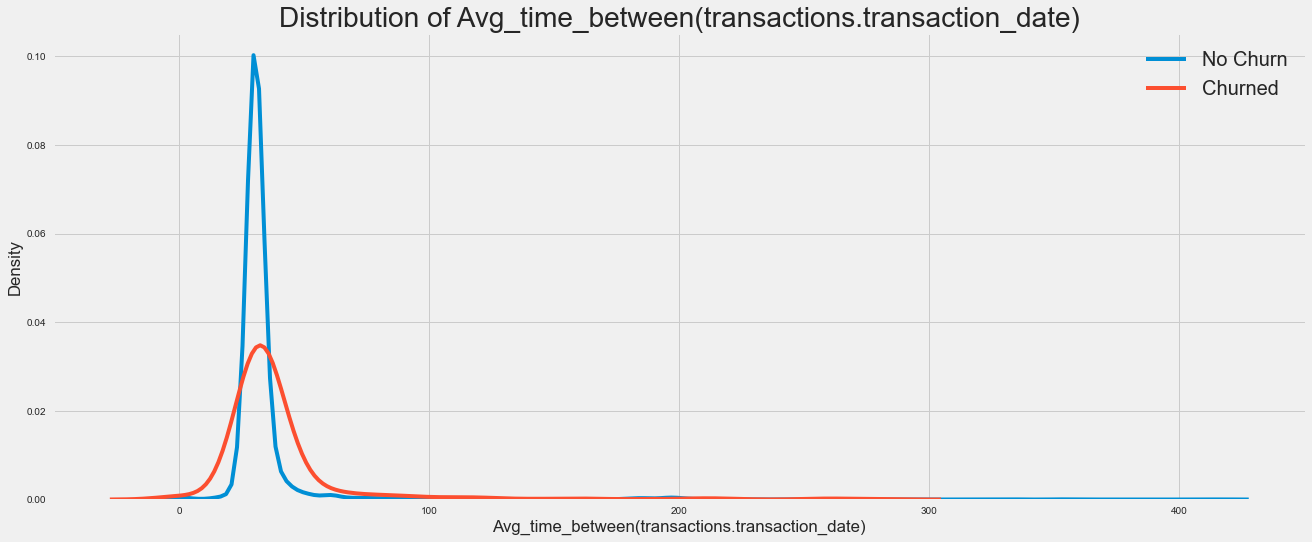

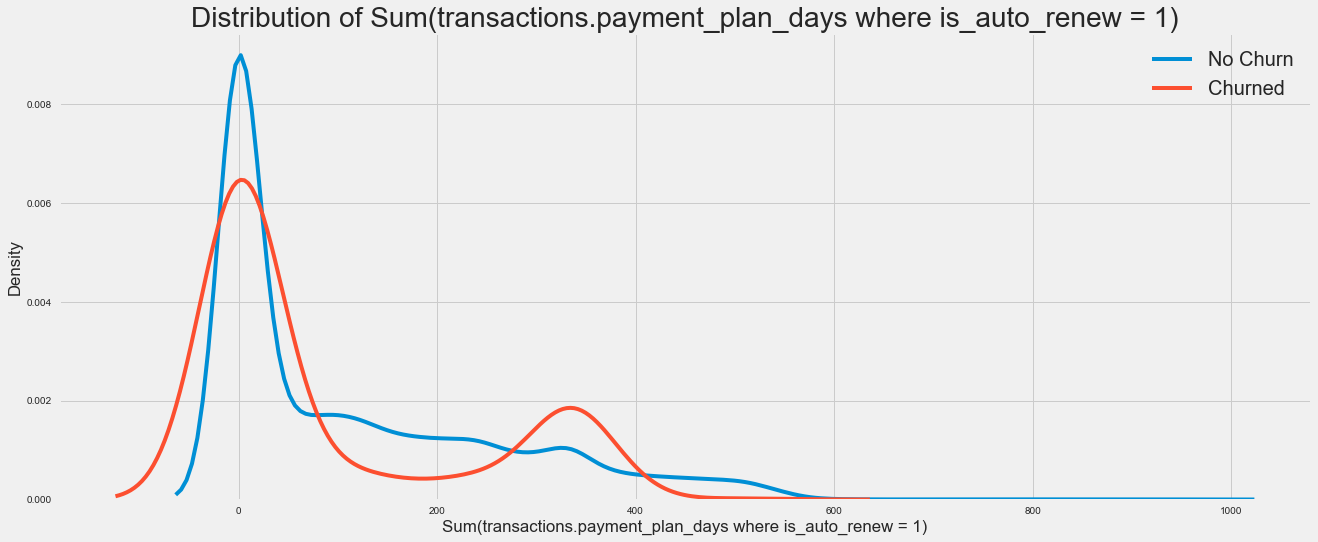

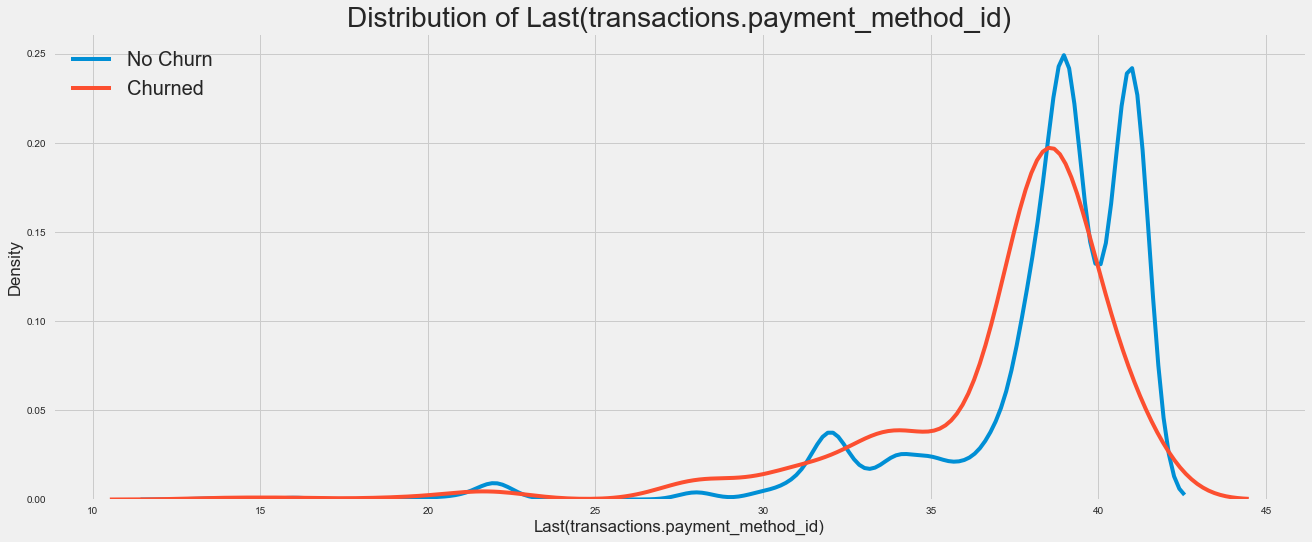

In [275]:
import seaborn as sns
plt.style.use('fivethirtyeight')

train_with_labels = train.copy()
train_with_labels['label'] = y
train_with_labels = train_with_labels.loc[train_with_labels[
    'TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)'] < 200]

train_with_labels['TIME_SINCE_LAST(transactions.transaction_date)'] = train_with_labels[
    'TIME_SINCE_LAST(transactions.transaction_date)'] / (3600 * 24)
train_with_labels['AVG_TIME_BETWEEN(transactions.transaction_date)'] = train_with_labels[
    'AVG_TIME_BETWEEN(transactions.transaction_date)'] / (3600 * 24)

# Iterate through features
for feature in ['TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)',
                'TIME_SINCE_LAST(transactions.transaction_date)',
                'AVG_TIME_BETWEEN(transactions.transaction_date)',
                'SUM(transactions.payment_plan_days WHERE is_auto_renew = 1)',
                'LAST(transactions.payment_method_id)']:
    plt.figure(figsize=(20, 8))

    # Iterate through values of the label
    for label, grouped in train_with_labels.groupby('label'):
        # Plot the distribution of the feature
        sns.kdeplot(grouped[feature].dropna(),
                    label='Churned' if label == 1 else 'No Churn')
    # Plot labeling
    plt.ylabel('Density')
    plt.xlabel(f'{feature.capitalize()}')
    plt.title(f'Distribution of {feature.capitalize()}', size=28)
    plt.legend(prop={'size': 20})

<Figure size 1440x576 with 0 Axes>

<AxesSubplot:xlabel='TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)', ylabel='Density'>

<AxesSubplot:xlabel='TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)', ylabel='Density'>

Text(0, 0.5, 'Density')

Text(0.5, 0, 'Total Spending in Month before Cutoff Time')

Text(0.5, 1.0, 'Distribution of Total Spending in Month before Cutoff Time')

<Figure size 1440x576 with 0 Axes>

<AxesSubplot:xlabel='TIME_SINCE_LAST(transactions.transaction_date)', ylabel='Density'>

<AxesSubplot:xlabel='TIME_SINCE_LAST(transactions.transaction_date)', ylabel='Density'>

Text(0, 0.5, 'Density')

Text(0.5, 0, 'Time Since Last Transaction')

Text(0.5, 1.0, 'Distribution of Time Since Last Transaction')

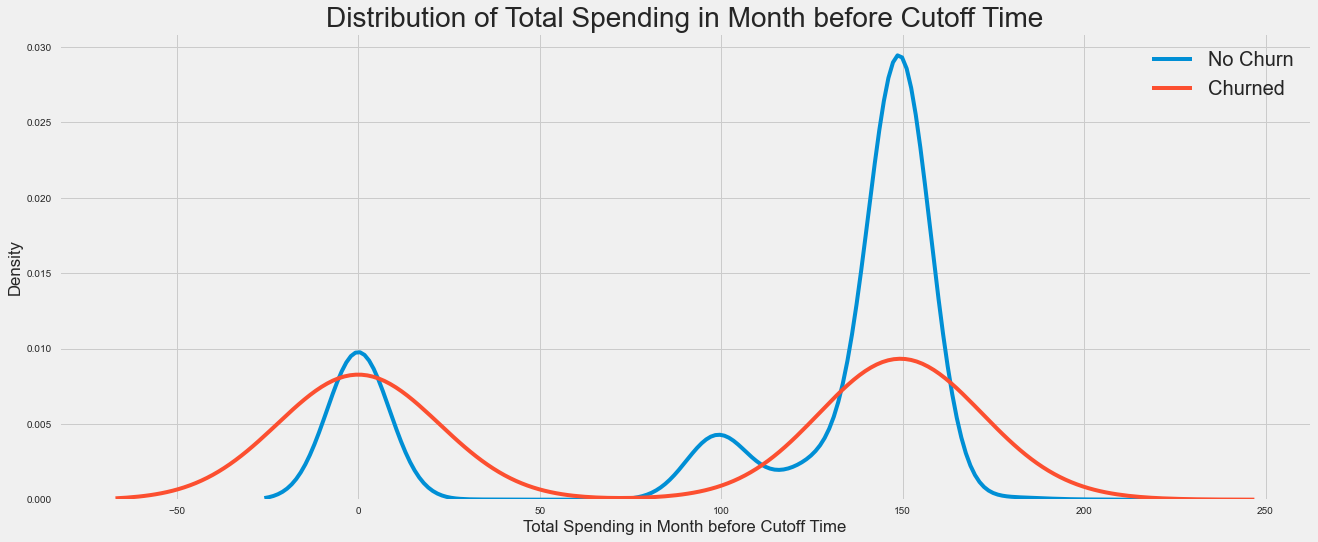

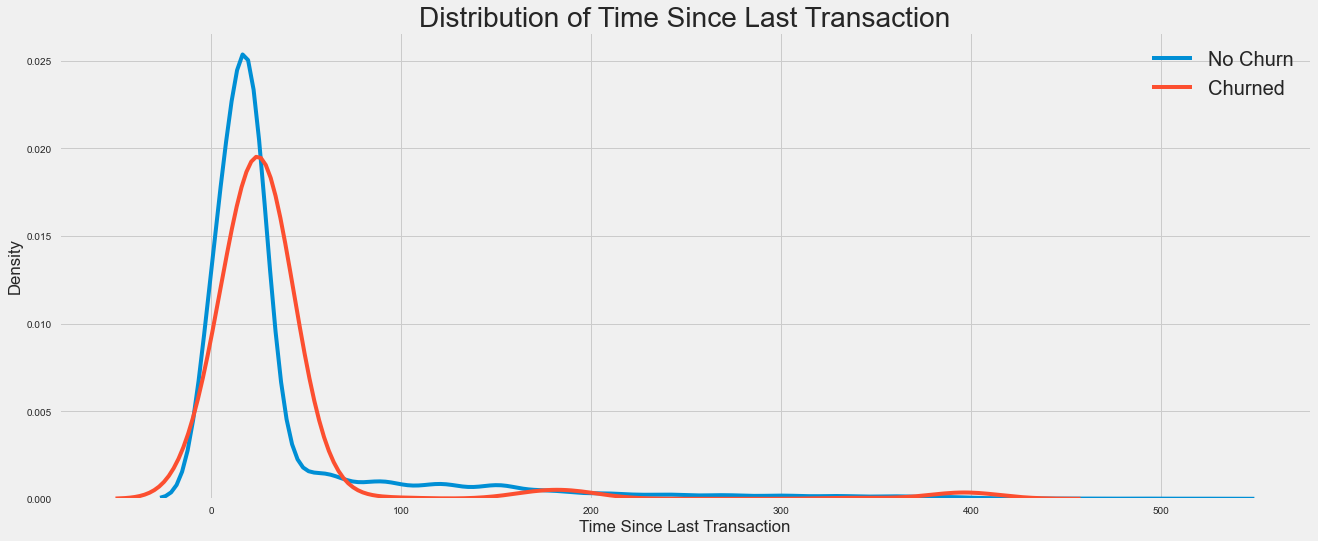

In [276]:
# Iterate through features
for feature, name in zip(['TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)',
                'TIME_SINCE_LAST(transactions.transaction_date)'], 
                         ['Total Spending in Month before Cutoff Time', 
                           'Time Since Last Transaction']):
    plt.figure(figsize=(20, 8))

    # Iterate through values of the label
    for label, grouped in train_with_labels.groupby('label'):
        # Plot the distribution of the feature
        sns.kdeplot(grouped[feature].dropna(),
                    label='Churned' if label == 1 else 'No Churn')
    # Plot labeling
    plt.ylabel('Density')
    plt.xlabel(f'{name}')
    plt.title(f'Distribution of {name}', size=28)
    plt.legend(prop={'size': 20})

## Difference between churn and non-churn customers:
These analyses clearly suggest that there is a difference between churn and non-churn customers in terms of total spending. Non-churned customers, intuitively, has spent more money. Interestingly, before auto-renew there was an increase in spending in the non-churn customers (compared to overall spending). This means that customers are trying to spend right before renewal process. This is an indication of high customer acquisition cost (CAC)

<Figure size 720x432 with 0 Axes>

Text(0, 0.5, 'Percentile')

Text(0.5, 0, 'Total spent in previous month')

Text(0.5, 1.0, 'ECDF of Total spent in previous month')

<Figure size 720x432 with 0 Axes>

Text(0, 0.5, 'Percentile')

Text(0.5, 0, 'Time since last transaction')

Text(0.5, 1.0, 'ECDF of Time since last transaction')

<Figure size 720x432 with 0 Axes>

Text(0, 0.5, 'Percentile')

Text(0.5, 0, 'Average time between transactions')

Text(0.5, 1.0, 'ECDF of Average time between transactions')

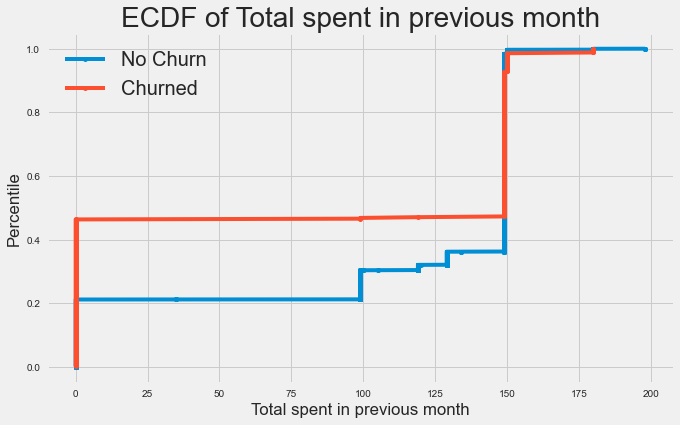

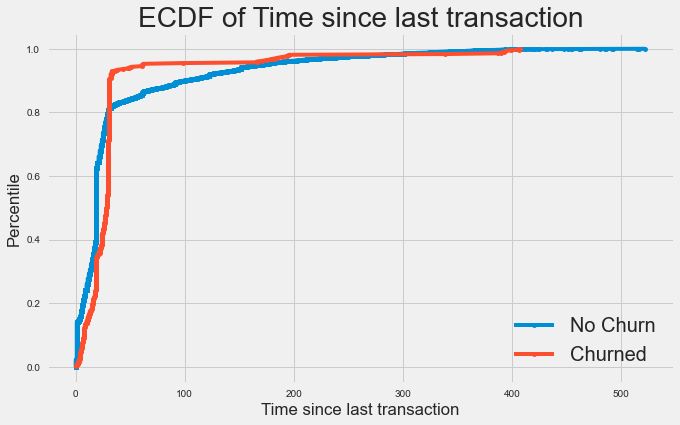

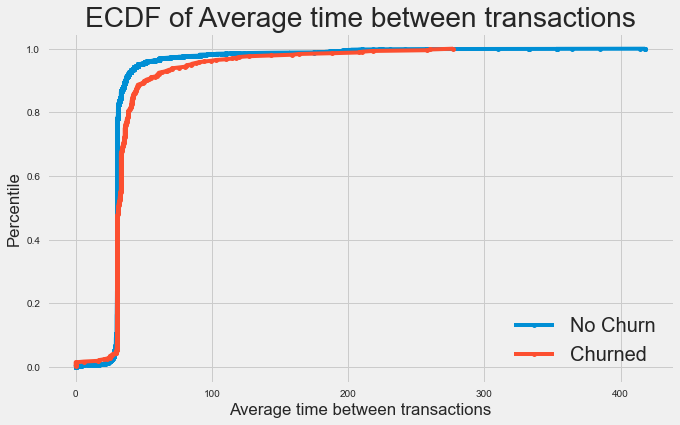

In [278]:
# Inspiration: https://campus.datacamp.com/courses/statistical-thinking-in-python-part-1/graphical-exploratory-data-analysis?ex=12
def ecdf(x):
    n = len(x)
    x = np.sort(x)
    y = np.arange(1, n + 1) / n
    return x, y

# Iterate through features
for feature, name in zip(['TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)',
                          'TIME_SINCE_LAST(transactions.transaction_date)',
                          'AVG_TIME_BETWEEN(transactions.transaction_date)'],
                         ['Total Spent in Previous Month',
                          'Time Since Last Transaction',
                          'Average Time Between Transactions']):
    plt.figure(figsize=(10, 6))

    # Iterate through values of the label
    for label, grouped in train_with_labels.groupby('label'):
        xs, ys = ecdf(grouped[feature])

        # Plot the distribution of the feature
        plt.plot(xs, ys, marker='.', ms=10,
                 label='Churned' if label == 1 else 'No Churn')

    # Plot labeling
    plt.ylabel('Percentile')
    plt.xlabel(f'{name.capitalize()}')
    plt.title(f'ECDF of {name.capitalize()}', size=28)
    plt.legend(prop={'size': 20})

In [282]:
new_probs = model.predict_proba(test)[:, 1]


oos_ids = list(feature_matrix_reset.loc[feature_matrix_reset['time'] >= split_date, 'msno'])
oos_cutoff_time = list(feature_matrix_reset.loc[feature_matrix_reset['time'] >= split_date, 'time'])

prediction_df = pd.DataFrame({'msno': oos_ids, 'time': oos_cutoff_time,
                              'probability': new_probs})
prediction_df['prediction'] = prediction_df['probability'] > threshold_required
prediction_df.sample(10)

,msno,time,probability,prediction
2929,GzmMeoll0Pf6mnNexXi6YnFcFYPVXqUpMH0v6ZXVppI=,2017-02-01,0.217580,False
7761,ju2z9hvdlika9p/fUA9NFG7tGH1smoP89hEGtXH1nRQ=,2017-04-01,0.070353,False
7985,lGLE8OaIiFxK+YGzjJxsGEqvlFMiyFvWSY2CzvCDXb0=,2016-10-01,0.318572,True
2092,BOD88yVtOXskkGOw/KBFozWrmIK64DeXXxbmLqaaLEY=,2016-12-01,0.005243,False
6624,d7ExctDu5QfGk87Lo8lVlAzVS6HLG8n7spErgfMf6IE=,2016-11-01,0.352217,True
6090,aBH1vNTX/rekK8pzxf+zRkHX9D1+/WCI93KMKJE1BKI=,2017-03-01,0.140276,False
843,3nhlQfumtKdrpQmM08i9j+6kfS6o3/lzRMFi8/kQNDI=,2017-04-01,0.429878,True
3849,N9fi72l/7EL0CsCg54//cU8neMNSHHwDl4K8IFsRkv8=,2017-02-01,0.008536,False
5319,WAgScmwVoWTiNJ7dPL8SqWelrocpooNxSzxwBMOPwFM=,2016-11-01,0.255885,True
8969,sUK9nv+pH14oh6flqmxrlQyDVJSkrlIhEZNBxuq9o/g=,2017-01-01,0.037074,False


<AxesSubplot:ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of Predicted Probabilities')

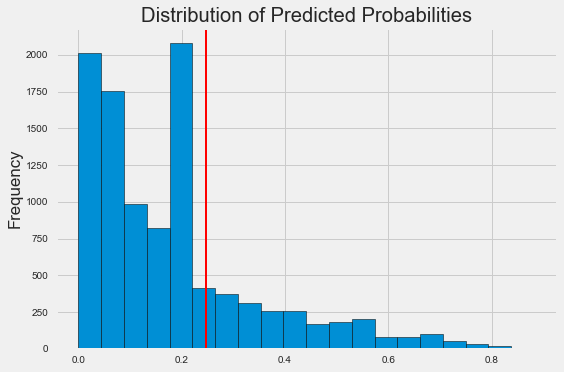

In [283]:
prediction_df['probability'].plot.hist(bins=20, edgecolor='k')
plt.axvline(x=threshold_required, color='r', linewidth=2)
plt.title('Distribution of Predicted Probabilities')

Text(0.5, 1.0, 'ECDF of Predicted Probobabilities')

Text(0.5, 0, 'Probability')

Text(0, 0.5, 'Percentile')

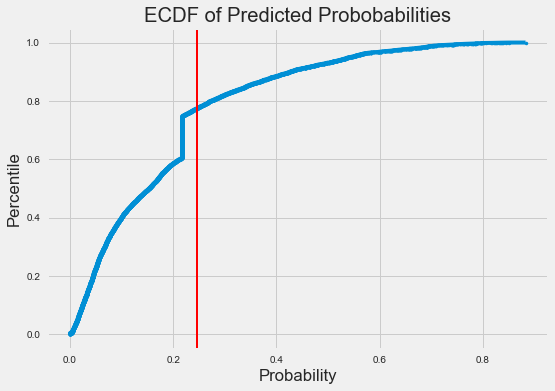

In [284]:
xs, ys = ecdf(prediction_df['probability'])
plt.plot(xs, ys, marker='.')
plt.title('ECDF of Predicted Probobabilities')
plt.axvline(x=threshold_required, color='r', linewidth=2)
plt.xlabel('Probability')
plt.ylabel('Percentile')

In [288]:
#pip install tpot
conda install -c conda-forge tpot

Retrieving notices: ...working... done
Note: you may need to restart the kernel to use updated packages.


C:\Users\aubhi\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'repo.anaconda.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings


Solving environment: ...working... unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\aubhi\anaconda3

  added / updated specs:
    - tpot


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0          11 KB  conda-forge
    ca-certificates-2023.7.22  |       h56e8100_0         146 KB  conda-forge
    certifi-2023.7.22          |     pyhd8ed1ab_0         150 KB  conda-forge
    deap-1.3.3                 |   py39h2e25243_0         158 KB  conda-forge
    libxgboost-1.6.1           |   cpu_h110a20b_1         2.5 MB  conda-forge
    py-xgboost-1.6.1           |cpu_py39ha538f94_1         156 KB  conda-forge
    stopit-1.1.2               |             py_0          16 KB  conda-forge
    t


  warnings.warn(
C:\Users\aubhi\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'conda.anaconda.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\aubhi\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'conda.anaconda.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\aubhi\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'repo.anaconda.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\aubhi\anaconda3\lib\sit

In [295]:
pip install tpot

  Obtaining dependency information for xgboost>=1.1.0 from https://files.pythonhosted.org/packages/75/dd/9afe0d9d0f61a5384c3932626a022e38c396a5d88e6f5345ad2f7b576747/xgboost-1.7.6-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 70.9/70.9 MB 10.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [291]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=3)

In [301]:
from tpot import TPOTClassifier

# Make tpot pipeline
tpot_pipeline = TPOTClassifier(generations=10, population_size=10,
                               cv=tss, scoring='f1',
                               n_jobs=-1, verbosity=2,
                               random_state=50)

tpot_pipeline.fit(scaled_train, y)

ImportError: cannot import name 'available_if' from 'sklearn.utils.metaestimators' (C:\Users\aubhi\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py)

In [293]:
pip install --upgrade scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/2d/30/3afb8bcb785653254eb646ff2680ec4d637b40b06f4b046aca17b5e086b0/scikit_learn-1.3.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/28/08/9dcdaa5aac4634e4c23af26d92121f7ce445c630efa0d3037881ae2407fb/joblib-1.3.1-py3-none-any.whl.metadata
   ---------------------------------------- 9.3/9.3 MB 4.3 MB/s eta 0:00:00
   ---------------------------------------- 302.0/302.0 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tpot 0.12.0 requires xgboost>=1.1.0, which is not installed.
bayesian-optimization 1.4.2 requires colorama>=0.4.6, but you have colorama 0.4.4 which is incompatible.
ydata-profiling 4.3.2 requires pydantic<2,>=1.8.1, but you have pydantic 2.0.3 which is incompatible.


In [299]:
!pip install numpy==1.22.4 pandas==1.2.4 dask-ml==2022.5.27 scikit-learn==1.1.1

  Using cached numpy-1.22.4-cp39-cp39-win_amd64.whl (14.7 MB)
     ---------------------------------------- 9.3/9.3 MB 9.4 MB/s eta 0:00:00
     -------------------------------------- 148.5/148.5 kB 9.2 MB/s eta 0:00:00
     ---------------------------------------- 7.4/7.4 MB 8.7 MB/s eta 0:00:00
  Obtaining dependency information for tornado>=6.0.3 from https://files.pythonhosted.org/packages/de/fa/b8b2ee2f528eedd03d98d49c76822f065f18e99f6f58c1e18fe5ed893098/tornado-6.3.2-cp38-abi3-win_amd64.whl.metadata
INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for numba>=0.51.0 from https://files.pythonhosted.org/packages/bc/43/a4a058fc1b58aa523b69141b98e51edf795fd0ff20e690dc8c1ed654c7fd/numba-0.57.1-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for llvmlite<0.41,>=0.40.0dev0 from https://files.pythonhosted.org/packages/e7/fb/a7430788e80cff1ec51

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\aubhi\\anaconda3\\Lib\\site-packages\\numpy\\.libs\\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



   from C:\Users\aubhi\AppData\Local\Temp\pip-uninstall-cxgdz4p8\core\include\numpy\npy_cpu.h
  Moving to c:\users\aubhi\anaconda3\lib\site-packages\numpy\core\include\numpy\npy_endian.h
   from C:\Users\aubhi\AppData\Local\Temp\pip-uninstall-cxgdz4p8\core\include\numpy\npy_endian.h
  Moving to c:\users\aubhi\anaconda3\lib\site-packages\numpy\core\include\numpy\npy_interrupt.h
   from C:\Users\aubhi\AppData\Local\Temp\pip-uninstall-cxgdz4p8\core\include\numpy\npy_interrupt.h
  Moving to c:\users\aubhi\anaconda3\lib\site-packages\numpy\core\include\numpy\npy_math.h
   from C:\Users\aubhi\AppData\Local\Temp\pip-uninstall-cxgdz4p8\core\include\numpy\npy_math.h
  Moving to c:\users\aubhi\anaconda3\lib\site-packages\numpy\core\include\numpy\npy_no_deprecated_api.h
   from C:\Users\aubhi\AppData\Local\Temp\pip-uninstall-cxgdz4p8\core\include\numpy\npy_no_deprecated_api.h
  Moving to c:\users\aubhi\anaconda3\lib\site-packages\numpy\core\include\numpy\npy_os.h
   from C:\Users\aubhi\AppData\Lo

   from C:\Users\aubhi\AppData\Local\Temp\pip-uninstall-cxgdz4p8\f2py\tests\__pycache__\test_assumed_shape.cpython-39.pyc
  Moving to c:\users\aubhi\anaconda3\lib\site-packages\numpy\f2py\tests\__pycache__\test_block_docstring.cpython-39.pyc
   from C:\Users\aubhi\AppData\Local\Temp\pip-uninstall-cxgdz4p8\f2py\tests\__pycache__\test_block_docstring.cpython-39.pyc
  Moving to c:\users\aubhi\anaconda3\lib\site-packages\numpy\f2py\tests\__pycache__\test_callback.cpython-39.pyc
   from C:\Users\aubhi\AppData\Local\Temp\pip-uninstall-cxgdz4p8\f2py\tests\__pycache__\test_callback.cpython-39.pyc
  Moving to c:\users\aubhi\anaconda3\lib\site-packages\numpy\f2py\tests\__pycache__\test_common.cpython-39.pyc
   from C:\Users\aubhi\AppData\Local\Temp\pip-uninstall-cxgdz4p8\f2py\tests\__pycache__\test_common.cpython-39.pyc
  Moving to c:\users\aubhi\anaconda3\lib\site-packages\numpy\f2py\tests\__pycache__\test_compile_function.cpython-39.pyc
   from C:\Users\aubhi\AppData\Local\Temp\pip-uninstall-c

In [300]:
tpot_pipeline.fitted_pipeline_
tpot_pipeline.export('best_pipeline_new.py')

NameError: name 'tpot_pipeline' is not defined